# CLUSTERIZAÇÃO DOS CLIENTES DA CERTIFICADORA DIGITAL

# DESCRIÇÃO SOBRE O PROJETO

O projeto em questão visa realizar a clusterização dos clientes da Certificadora Digital a fim facilitar e direcionar o trabalho do setor de pós-venda para otimizar tempo e produzir ações mais eficientes.

## Input de dados

O dataset possuí dados de:
1) Cadastro de unidades
2) Pedidos de venda
3) Pedidos revogados
4) Análises de pedidos

## Output de dados

1) Indicação do melhor grupo de unidades da empresa
2) Relatório com as seguintes perguntas respondidas:
- Quem são as unidades elegíveis para participar do melhor grupo?
- Quantas unidades farão parte do grupo?
- Quais as principais características das unidades desse grupo?
- Qual a porcentagem de contribuição do faturamento vinda deste grupo?
- Quais as condições para uma pessoa ser elegível ao melhor grupo?
- Quais as condições para uma pessoa ser removida do melhor grupo?
- Sobre os outros grupos, quais ações o time de marketing pode realizar para aumentar o faturamento?

1. **Quem são as unidades elegíveis para participar do melhor grupo?**
    - Unidade que gera um alto faturamento
    - Tem uma taxa de emissão de certificados por tempo ativo alta
    - Baixa probabilidade de churn
    - Baixa recência e alta frequência
    - Relação qtde de análises/qtde de certificados emitidos baixa
    - Relação qtde de pedidos revogados/qtdede certificados emitidos baixa
2. **Quantas unidades farão parte do grupo?**
    - Espera-se 10% da base de unidades
3. **Quais as principais características das unidades desse grupo?**
    - Descrever o perfil do melhor cluster
4. **Qual a porcentagem de contribuição do faturamento vinda deste grupo?**
    - Espera-se 30% do faturamento total da base de unidades
5. **Quais as condições para uma pessoa ser elegível ao melhor grupo?**
    - O desempenho da unidade deverá estar próxima ao desempenho médio do melhor cluster
6. **Quais as condições para uma pessoa ser removida do melhor grupo?**
    - O desempenho da unidade deverá se afastar do desempenho médio do melhor cluster
7. **Sobre os outros grupos, quais ações o time de marketing e/ou pós-venda pode realizar para aumentar o faturamento?**
    - Realizar o descredenciamento das unidades com baixo desempenho
    - Incentivar os clusters médios a emitir com mais frequência
    - Reduzir valores de tabelas de preço da unidade junto ao comercial

# 0 - IMPORTS

In [1]:
import pickle

import pandas                      as pd
import numpy                       as np
import seaborn                     as sns
import umap.umap_                  as umap

import matplotlib.pyplot           as plt
from matplotlib.gridspec           import GridSpec

from sklearn                       import preprocessing                   as pp
from sklearn                       import decomposition                   as dd
from sklearn.manifold              import TSNE                            as mn
from sklearn                       import ensemble                        as en
from sklearn                       import cluster                         as c
from sklearn                       import metrics                         as m
from sklearn                       import mixture                         as mx

from scipy.cluster                 import hierarchy                       as hc

## 0.1 - Helper functions

## 0.2 - Load dataset

### 0.2.1 - Loading

In [2]:
# Pedido de venda
pv_f = pickle.load(open('datasets/pv_f.pkl', 'rb'))

# Cadastro de vendedor
cv_f = pickle.load(open('datasets/cv_f.pkl', 'rb'))

# Registro de análises e recusas
rar_f = pickle.load(open('datasets/rar_f.pkl', 'rb'))

# Pedido revogado
pvr_f = pd.read_csv('datasets/pedido_cancelado.csv', sep=';')

### 0.2.2 - RAW

In [3]:
# pv_f
#1 Colune ano_mes
pv_f['ano_mes'] = pv_f.loc[:, 'data'].apply(lambda x: x.strftime('%Y-%m'))
#2 Coluna id
pv_f['id'] = pv_f.loc[:, 'empresa_vendedor'] + pv_f.loc[:, 'ano_mes']
# cv_f
#1 Merge pv_f e cv_f
df_raw = pd.merge(pv_f, cv_f.loc[:, ['data_nasc', 'agr_ativo', 'empresa_vendedor', 'tipo_unidade', 'gestor_comercial', 
                                     'segmento', 'municipio', 'uf', 'regiao', 'unidade_ativa', 'gestor_credenc', 
                                     't_hab_total', 'tempo_ativo_unid', 'tempo_1pedido_unid']], 
                                     how='left', on='empresa_vendedor')

# rar_f
#1 Filtro
rar_f = rar_f[rar_f['tipo']=='ANALISE'].copy()
#2 Ajuste e criação de features
rar_f['data'] = rar_f.loc[:, 'data'].apply(lambda x: x.strftime('%Y-%m'))
rar_f['tempo_total_analise'] = rar_f.loc[:, 'tempo_espera'] + rar_f.loc[:, 'tempo_analise']
rar_f['qtde_analises'] = 1
rar_f['id'] = rar_f.loc[:, 'empresa_vendedor'] + rar_f.loc[:, 'data']
#3 Groupby
rar_f = rar_f.loc[:, ['id', 'tempo_total_analise', 'qtde_analises']].groupby('id').sum().reset_index()
#4 Merge df_raw e rar_f
df_raw = pd.merge(df_raw, rar_f, how='left', on='id')

# pvr_f
#1 Filtro
pvr_f = pvr_f[pvr_f['tipo_produto']=='certificado']
#2 Ajuste e criação de features
pvr_f['data'] = pd.to_datetime(pvr_f.loc[:, 'data']).apply(lambda x: x.strftime('%Y-%m'))
pvr_f['id'] = pvr_f.loc[:, 'empresa_vendedor'] + pvr_f.loc[:, 'data']
#3 Groupby
pvr_f = pvr_f[['id', 'qtde']].groupby('id').sum().reset_index().rename(columns={'qtde': 'qtde_revogados'})
#4 Merge df_raw e pvr_f
df_raw = pd.merge(df_raw, pvr_f, how='left', on='id')

# Selecting columns
df_raw = df_raw.loc[:,['data', 'valor_total_nf', 'produto', 'forma_pagamento', 'eh_renovacao', 'renovou', 'empresa', 'empresa_vendedor', 
                       'empresa_indicador', 'qtde', 'tipo_produto', 'empresa_cliente', 'empresa_unidade', 'ano_mes', 'agr_ativo', 
                       'tipo_unidade', 'gestor_comercial', 'segmento', 'municipio', 'uf', 'regiao', 'unidade_ativa', 'tempo_ativo_unid', 
                       'tempo_total_analise', 'qtde_analises', 'qtde_revogados']]

# 1 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1 - Data dimensions

In [5]:
print('Number of rows: {}\nNumber of columns: {}'.format(df1.shape[0], df1.shape[1]))

Number of rows: 214810
Number of columns: 26


## 1.2 - Data types

In [6]:
df1.dtypes

data                   datetime64[ns]
valor_total_nf                 object
produto                        object
forma_pagamento                object
eh_renovacao                   object
renovou                        object
empresa                        object
empresa_vendedor               object
empresa_indicador              object
qtde                            int64
tipo_produto                   object
empresa_cliente                object
empresa_unidade                object
ano_mes                        object
agr_ativo                      object
tipo_unidade                   object
gestor_comercial               object
segmento                       object
municipio                      object
uf                             object
regiao                         object
unidade_ativa                  object
tempo_ativo_unid              float64
tempo_total_analise           float64
qtde_analises                 float64
qtde_revogados                float64
dtype: objec

## 1.3 - Check NA

In [7]:
df1.isna().sum()

data                        0
valor_total_nf              0
produto                     0
forma_pagamento             0
eh_renovacao              473
renovou                     0
empresa                     0
empresa_vendedor            0
empresa_indicador      155674
qtde                        0
tipo_produto                0
empresa_cliente             0
empresa_unidade           523
ano_mes                     0
agr_ativo                1157
tipo_unidade             1157
gestor_comercial         1157
segmento                 1157
municipio                2081
uf                       1157
regiao                   1157
unidade_ativa            1157
tempo_ativo_unid         3922
tempo_total_analise     39574
qtde_analises           39574
qtde_revogados         181080
dtype: int64

## 1.4 - Replace NA

In [8]:
# eh_renovacao
df1['eh_renovacao'] = df1['eh_renovacao'].fillna('Nao')

# empresa_indicador
df1['empresa_indicador'] = df1['empresa_indicador'].fillna('NAO POSSUI')

# empresa_unidade
df1 = df1.dropna(subset=['empresa_unidade'])

# agr_ativo
df1 = df1.dropna(subset=['agr_ativo'])

# municipio
df1['municipio'] = df1['municipio'].fillna('INDEFINIDO')

# tempo_ativo_unid
#1 Cálculo do tempo ativo
data_max = pd.Timestamp(2022,12,12,23,59,59) # data máxima de pv_f
aux = df1[['empresa_vendedor', 'data']].sort_values(['empresa_vendedor', 'data']).drop_duplicates(subset='empresa_vendedor', keep='first')
aux['tempo_ativo_unid_subs'] = (data_max - aux.loc[:, 'data']).dt.days
aux = aux.loc[:, ['empresa_vendedor', 'tempo_ativo_unid_subs']]
#2 Merge e substituição
df1 = pd.merge(df1, aux, how='left', on='empresa_vendedor')
df1['tempo_ativo_unid'] = df1[['tempo_ativo_unid', 'tempo_ativo_unid_subs']].apply(lambda x: x['tempo_ativo_unid'] if pd.notnull(x['tempo_ativo_unid']) else x['tempo_ativo_unid_subs'], axis=1)
#3 Drop
df1 = df1.drop('tempo_ativo_unid_subs', axis=1)
#4 Filtro (somente pedidos a partir de 01/03/2022 - momento em que as análises começaram)
df1 = df1[df1['data']>='2021-03-01 00:00:00']

# tempo_total_analise
df1['tempo_total_analise'] = df1['tempo_total_analise'].fillna(257) # Tempo de análise médio

# qtde_analises
df1['qtde_analises'] = df1['qtde_analises'].fillna(1)

# qtde_revogados
df1['qtde_revogados'] = df1['qtde_revogados'].fillna(0)

df1.isna().sum()

data                   0
valor_total_nf         0
produto                0
forma_pagamento        0
eh_renovacao           0
renovou                0
empresa                0
empresa_vendedor       0
empresa_indicador      0
qtde                   0
tipo_produto           0
empresa_cliente        0
empresa_unidade        0
ano_mes                0
agr_ativo              0
tipo_unidade           0
gestor_comercial       0
segmento               0
municipio              0
uf                     0
regiao                 0
unidade_ativa          0
tempo_ativo_unid       0
tempo_total_analise    0
qtde_analises          0
qtde_revogados         0
dtype: int64

## 1.5 - Change dtypes

In [9]:
# valor_total_nf
df1['valor_total_nf'] = df1['valor_total_nf'].str.replace(',', '.').astype(float)

## 1.6 - Estatística descritiva

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 - Numerical attributes

In [11]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenação
stats = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
stats

attributes  min         max       range           mean    median  \
0       valor_total_nf  0.0       539.0       539.0     108.242501       NaN   
1                 qtde  1.0         1.0         0.0       1.000000       1.0   
2     tempo_ativo_unid  3.0      1459.0      1456.0     723.233834     761.0   
3  tempo_total_analise  0.0  13108575.0  13108575.0  617942.600914  203997.0   
4        qtde_analises  1.0       350.0       349.0      60.943621      29.0   
5       qtde_revogados  0.0         8.0         8.0       0.220141       0.0   

            std      skew   kurtosis  
0  4.105354e+01  1.857062   4.791825  
1  0.000000e+00  0.000000   0.000000  
2  3.177223e+02  0.249615   0.003601  
3  1.059429e+06  3.822535  23.575094  
4  6.947991e+01  1.694392   2.346504  
5  5.755409e-01  3.282115  13.658250

C:\Users\faust\AppData\Local\Temp\ipykernel_46728\1045576096.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax=ax, bins=50);


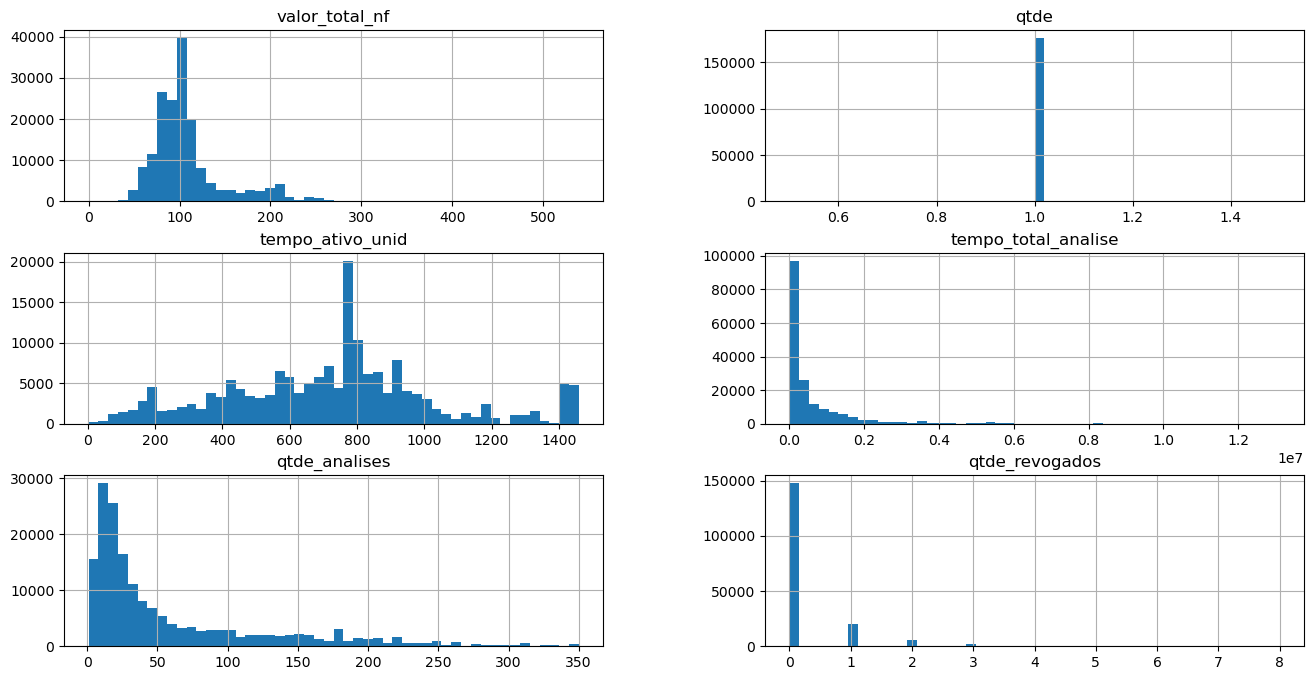

In [12]:
fig = plt.figure(figsize=[16, 8])
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50);

### 1.6.2 - Categorical attributes

In [13]:
values_cat = pd.DataFrame({'feature': cat_attributes.columns, 'distinct_values': [len(list(cat_attributes[i].unique())) for i in list(cat_attributes.columns)]})
values_cat

feature  distinct_values
0             produto               36
1     forma_pagamento               58
2        eh_renovacao                2
3             renovou                2
4             empresa               11
5    empresa_vendedor             1286
6   empresa_indicador             1829
7        tipo_produto                2
8     empresa_cliente           152302
9     empresa_unidade             1096
10            ano_mes               22
11          agr_ativo                2
12       tipo_unidade                2
13   gestor_comercial               19
14           segmento                4
15          municipio              580
16                 uf               28
17             regiao                6
18      unidade_ativa                2

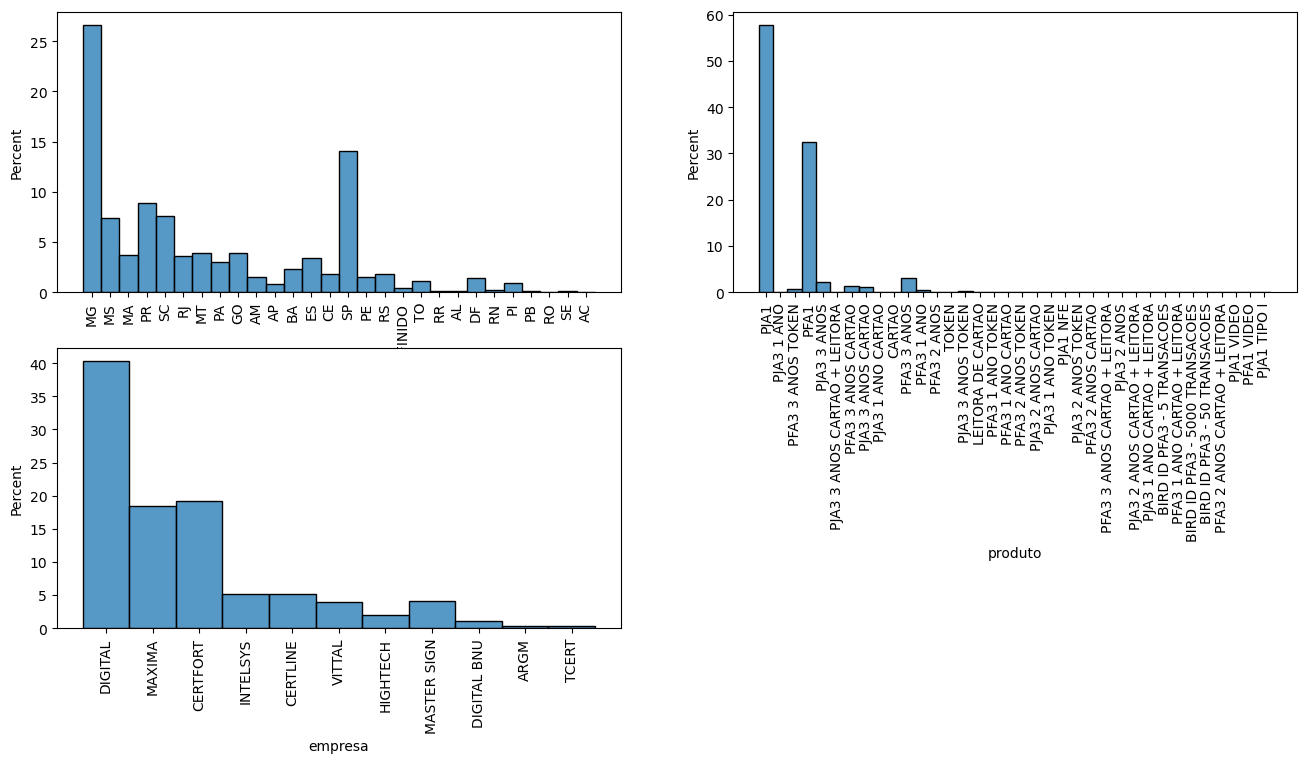

In [14]:
# Selecionando algumas features para análise
plt.figure(figsize=[16, 8])
plt.subplot(2, 2, 1)
sns.histplot(x='uf', data=cat_attributes, stat='percent')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.histplot(x='produto', data=cat_attributes, stat='percent')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.histplot(x='empresa', data=cat_attributes, stat='percent')
plt.xticks(rotation=90);

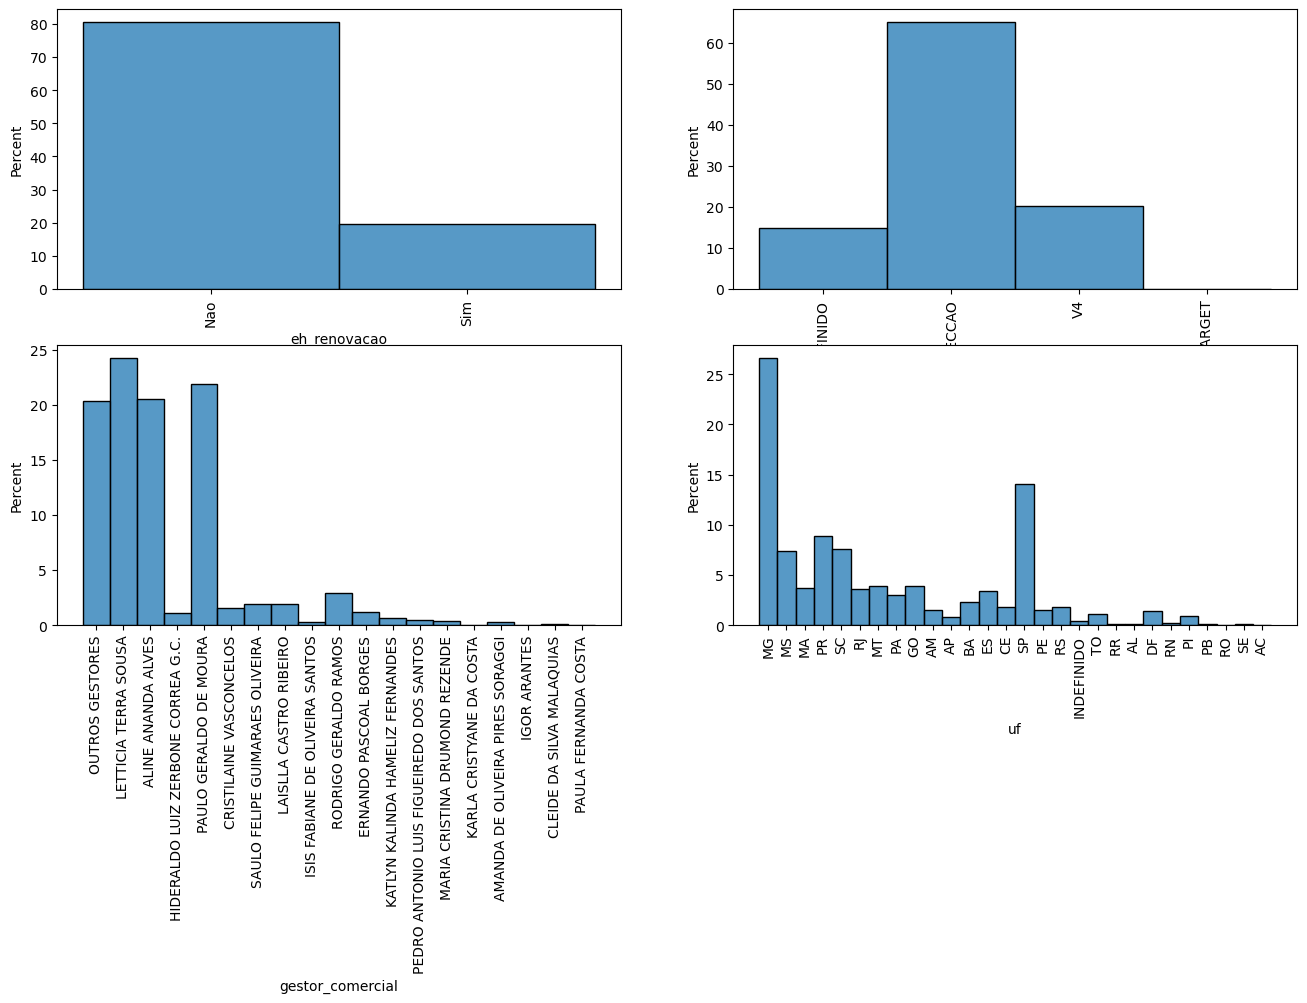

In [15]:
plt.figure(figsize=[16, 8])
plt.subplot(2, 2, 1)
sns.histplot(x='eh_renovacao', data=cat_attributes, stat='percent')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.histplot(x='segmento', data=cat_attributes, stat='percent')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.histplot(x='gestor_comercial', data=cat_attributes, stat='percent')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.histplot(x='uf', data=cat_attributes, stat='percent')
plt.xticks(rotation=90);

# 2 - FILTRAGEM DE VARIÁVEIS

In [16]:
df2 = df1.copy()

## 2.1 - Seleção de linhas

In [17]:
# Somente unidades com tipo diferente de 'Sede'
df2 = df2[df2['tipo_unidade']!='Sede']

# Somente produtos do tipo 'certificado'
df2 = df2[df2['tipo_produto']=='certificado']

# Somente agrs ativos e unidades ativas
df2 = df2[(df2['unidade_ativa']=='Sim') & (df2['agr_ativo']=='Sim')]

In [18]:
print('Número de linhas remanescentes: {}'.format(df2.shape[0]))

Número de linhas remanescentes: 120399


## 2.2 - Seleção de colunas

In [19]:
df2 = df2.drop(['renovou', 'empresa_vendedor', 'empresa_cliente', 'unidade_ativa', 'agr_ativo', 'tipo_produto'], axis=1)

In [20]:
print('Número de colunas remanescentes: {}'.format(df2.shape[1]))

Número de colunas remanescentes: 20


# 3 - FEATURE ENGINEERING

In [21]:
df3 = df2.copy()

In [22]:
# data reference
df_ref = df3[['empresa_unidade']].copy()
df_ref = df_ref.drop_duplicates(ignore_index=True)

## 3.1 - Faturamento (monetary)

In [23]:
aux = df3[['empresa_unidade', 'valor_total_nf']].groupby('empresa_unidade').sum().reset_index()

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')
df_ref.isna().sum()

empresa_unidade    0
valor_total_nf     0
dtype: int64

## 3.2 - Qtde de dias após a última compra (recência)

In [24]:
aux = df3[['empresa_unidade', 'data']].sort_values(['empresa_unidade', 'data'], ascending=(True, False)).drop_duplicates('empresa_unidade', keep='first')
aux['recencia_dias'] = (data_max - aux['data']).dt.days

# Merge
df_ref = pd.merge(df_ref, aux.loc[:, ['empresa_unidade', 'recencia_dias']], how='left', on='empresa_unidade')
df_ref.isna().sum()

empresa_unidade    0
valor_total_nf     0
recencia_dias      0
dtype: int64

## 3.3 - Qtde de emissões (frequência)

In [25]:
aux = df3[['empresa_unidade', 'qtde']].groupby('empresa_unidade').sum().reset_index().rename(columns={'qtde': 'frequencia'})

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')
df_ref.isna().sum()

empresa_unidade    0
valor_total_nf     0
recencia_dias      0
frequencia         0
dtype: int64

## 3.4 - Qtde de produtos diferentes

In [26]:
aux = df3.loc[:, ['empresa_unidade', 'produto']].drop_duplicates(['empresa_unidade', 'produto'])\
                                                .groupby('empresa_unidade').size().reset_index()\
                                                .rename(columns={0: 'qtde_produtos_diferentes'})

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')
df_ref.isna().sum()

empresa_unidade             0
valor_total_nf              0
recencia_dias               0
frequencia                  0
qtde_produtos_diferentes    0
dtype: int64

## 3.5 - Média do faturamento por pedido

In [27]:
aux = df3[['empresa_unidade', 'valor_total_nf']].groupby('empresa_unidade').mean().reset_index().rename(columns={'valor_total_nf': 'ticket_medio'})

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')
df_ref.isna().sum()

empresa_unidade             0
valor_total_nf              0
recencia_dias               0
frequencia                  0
qtde_produtos_diferentes    0
ticket_medio                0
dtype: int64

## 3.6 - Média da recência

In [28]:
aux = df3[['empresa_unidade', 'data']].drop_duplicates().sort_values(['empresa_unidade', 'data'], ascending=(False, False))
aux['proxima_unidade'] = aux['empresa_unidade'].shift(-1)
aux['data_anterior'] = aux['data'].shift(-1)
aux['media_recencia_dias'] = aux.apply(lambda x: (x['data'] - x['data_anterior']).days if x['empresa_unidade']==x['proxima_unidade'] else np.nan, axis=1)
aux = aux.loc[:, ['empresa_unidade', 'media_recencia_dias']].groupby('empresa_unidade').mean().reset_index()

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Preenchendo NAs
df_ref['media_recencia_dias'] = df_ref[['media_recencia_dias', 'recencia_dias']].apply(lambda x: x['recencia_dias'] if pd.isnull(x['media_recencia_dias']) else
                                                                                                 x['media_recencia_dias'], axis=1)
df_ref.isna().sum()

empresa_unidade             0
valor_total_nf              0
recencia_dias               0
frequencia                  0
qtde_produtos_diferentes    0
ticket_medio                0
media_recencia_dias         0
dtype: int64

## 3.7 - Número de revogações

In [29]:
aux = df3[['empresa_unidade', 'ano_mes', 'qtde_revogados']].groupby(['empresa_unidade', 'ano_mes']).mean().reset_index()
aux = aux.loc[:, ['empresa_unidade', 'qtde_revogados']].groupby('empresa_unidade').sum().reset_index()

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')
df_ref.isna().sum()

empresa_unidade             0
valor_total_nf              0
recencia_dias               0
frequencia                  0
qtde_produtos_diferentes    0
ticket_medio                0
media_recencia_dias         0
qtde_revogados              0
dtype: int64

## 3.8 - Média de qtde de emissões por tempo ativo

In [30]:
aux = df3[['empresa_unidade', 'tempo_ativo_unid']].groupby('empresa_unidade').mean().reset_index()

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Cálculo
df_ref['media_frequencia_tempo_ativo'] = df_ref.loc[:, 'frequencia']/df_ref.loc[:, 'tempo_ativo_unid']
df_ref = df_ref.drop('tempo_ativo_unid', axis=1)

df_ref.isna().sum()

empresa_unidade                 0
valor_total_nf                  0
recencia_dias                   0
frequencia                      0
qtde_produtos_diferentes        0
ticket_medio                    0
media_recencia_dias             0
qtde_revogados                  0
media_frequencia_tempo_ativo    0
dtype: int64

## 3.9 - Média de qtde de emissões por tempo total de analise

In [31]:
aux = df3[['empresa_unidade', 'tempo_total_analise']].groupby('empresa_unidade').mean().reset_index()

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Cálculo
df_ref['media_frequencia_tempo_analise'] = df_ref.loc[:, 'frequencia']/df_ref.loc[:, 'tempo_total_analise']
df_ref = df_ref.drop('tempo_total_analise', axis=1)

df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
dtype: int64

## 3.10 - Média de qtde de emissões por qtde de análises

In [32]:
aux = df3[['empresa_unidade', 'qtde_analises']].groupby('empresa_unidade').mean().reset_index()

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Cálculo
df_ref['media_frequencia_qtde_analises'] = df_ref.loc[:, 'frequencia']/df_ref.loc[:, 'qtde_analises']
df_ref = df_ref.drop('qtde_analises', axis=1)

df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
dtype: int64

## 3.11 - Qtde de renovações

In [33]:
aux = df3.loc[df3['eh_renovacao']=='Sim', ['empresa_unidade', 'eh_renovacao']]
aux = aux.groupby('empresa_unidade').size().reset_index().rename(columns={0: 'qtde_renovacoes'})

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Preenchendo NAs
df_ref['qtde_renovacoes'] = df_ref.loc[:, 'qtde_renovacoes'].fillna(0)

df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
qtde_renovacoes                   0
dtype: int64

## 3.12 - Representatividade das renovações na frequência

In [34]:
df_ref['represent_renovacoes'] = df_ref.loc[:, 'qtde_renovacoes']/df_ref.loc[:, 'frequencia']
df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
qtde_renovacoes                   0
represent_renovacoes              0
dtype: int64

## 3.13 - Qtde de emissões com indicação

In [35]:
aux = df3.loc[df3['empresa_indicador']!='NAO POSSUI', ['empresa_unidade', 'empresa_indicador']]
aux = aux.groupby('empresa_unidade').size().reset_index().rename(columns={0: 'qtde_indicacoes'})

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Preenchendo NAs
df_ref['qtde_indicacoes'] = df_ref.loc[:, 'qtde_indicacoes'].fillna(0)

df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
qtde_renovacoes                   0
represent_renovacoes              0
qtde_indicacoes                   0
dtype: int64

## 3.14 - Representatividade das indicações

In [36]:
df_ref['represent_indicacoes'] = df_ref.loc[:, 'qtde_indicacoes']/df_ref.loc[:, 'frequencia']
df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
qtde_renovacoes                   0
represent_renovacoes              0
qtde_indicacoes                   0
represent_indicacoes              0
dtype: int64

## 3.15 - Qtde de vouchers

In [37]:
aux = df3.loc[df3['forma_pagamento']=='VOUCHER', ['empresa_unidade', 'forma_pagamento']]
aux = aux.groupby('empresa_unidade').size().reset_index().rename(columns={0: 'qtde_vouchers'})

# Merge
df_ref = pd.merge(df_ref, aux, how='left', on='empresa_unidade')

# Preenchendo NAs
df_ref['qtde_vouchers'] = df_ref.loc[:, 'qtde_vouchers'].fillna(0)

df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
qtde_renovacoes                   0
represent_renovacoes              0
qtde_indicacoes                   0
represent_indicacoes              0
qtde_vouchers                     0
dtype: int64

## 3.14 - Representatividade dos vouchers

In [38]:
df_ref['represent_vouchers'] = df_ref.loc[:, 'qtde_vouchers']/df_ref.loc[:, 'frequencia']
df_ref.isna().sum()

empresa_unidade                   0
valor_total_nf                    0
recencia_dias                     0
frequencia                        0
qtde_produtos_diferentes          0
ticket_medio                      0
media_recencia_dias               0
qtde_revogados                    0
media_frequencia_tempo_ativo      0
media_frequencia_tempo_analise    0
media_frequencia_qtde_analises    0
qtde_renovacoes                   0
represent_renovacoes              0
qtde_indicacoes                   0
represent_indicacoes              0
qtde_vouchers                     0
represent_vouchers                0
dtype: int64

# 4 - ANÁLISE EXPLORATÓRIA DE DADOS ANTES DA MODELAGEM

In [39]:
df4 = df_ref.copy()

## 4.1 - Análise univariada

In [40]:
columns = df4.columns[1:]

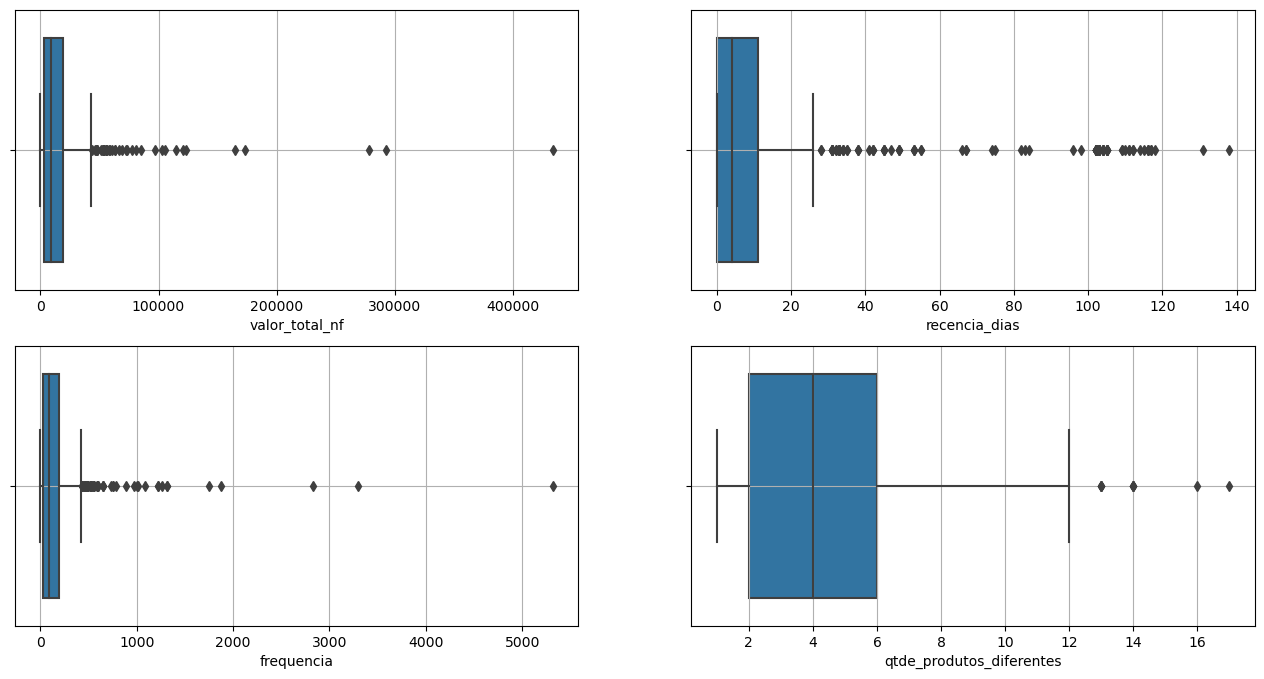

In [41]:
passe = 0
plt.figure(figsize=[16, 8])
for i in range(passe*4, (passe+1)*4):
    plt.subplot(2, 2, i+1-4*passe)
    sns.boxplot(x=columns[i], data=df4)
    plt.grid()

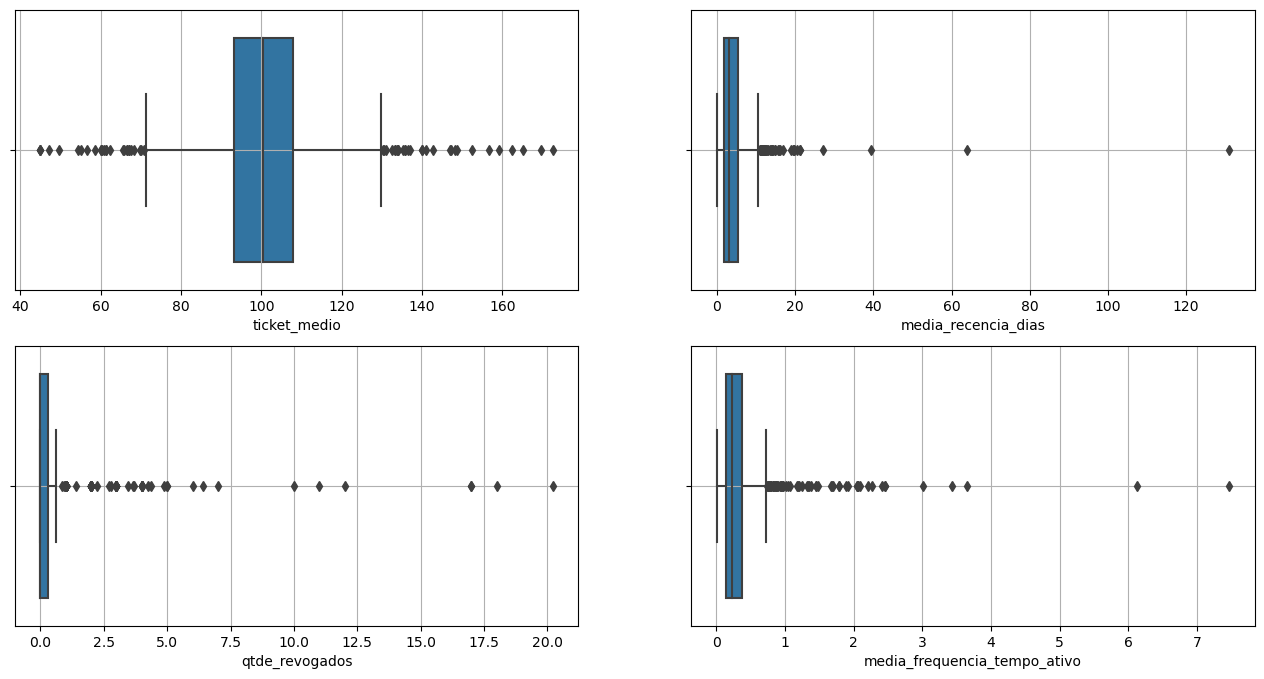

In [42]:
passe = 1
plt.figure(figsize=[16, 8])
for i in range(passe*4, (passe+1)*4):
    plt.subplot(2, 2, i+1-4*passe)
    sns.boxplot(x=columns[i], data=df4)
    plt.grid()

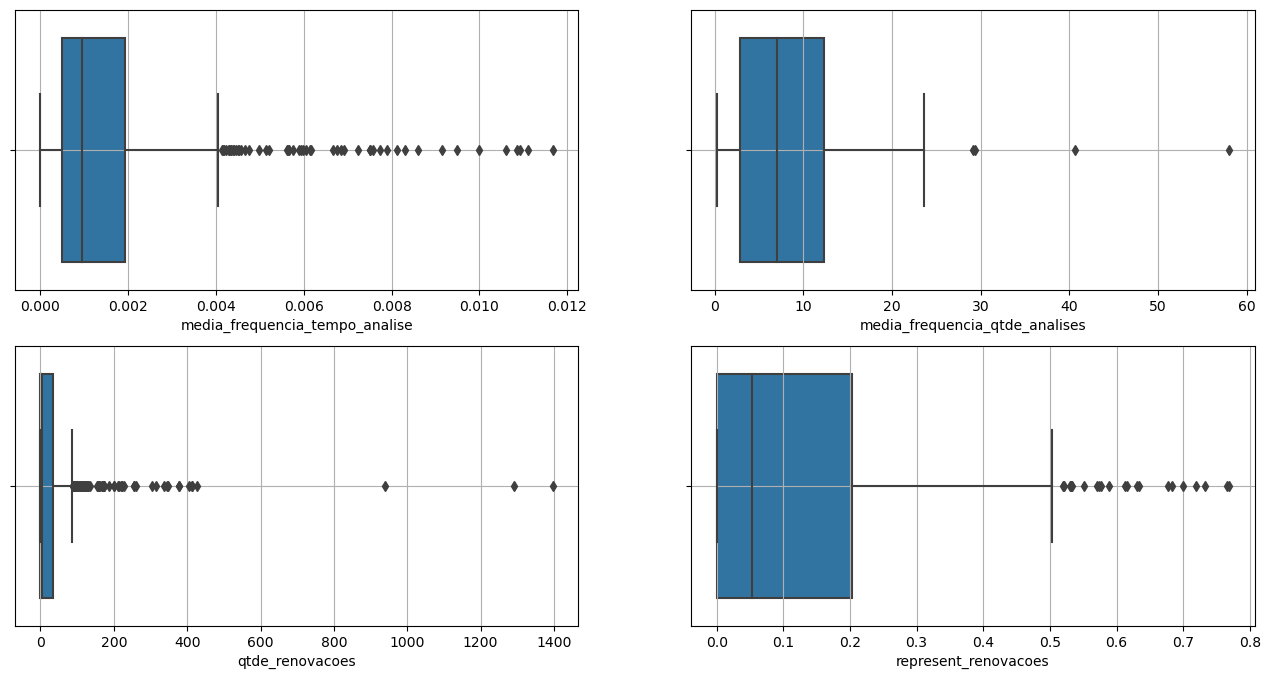

In [43]:
passe = 2
plt.figure(figsize=[16, 8])
for i in range(passe*4, (passe+1)*4):
    plt.subplot(2, 2, i+1-4*passe)
    sns.boxplot(x=columns[i], data=df4)
    plt.grid()

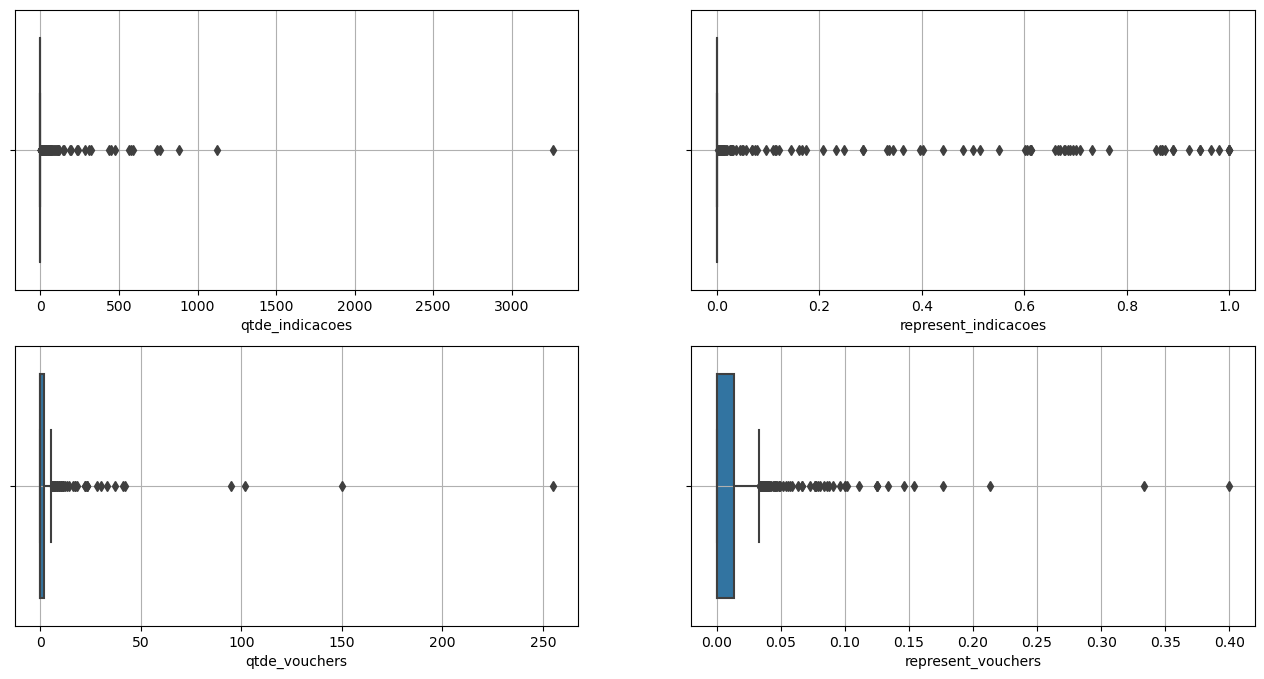

In [44]:
passe = 3
plt.figure(figsize=[16, 8])
for i in range(passe*4, (passe+1)*4):
    plt.subplot(2, 2, i+1-4*passe)
    sns.boxplot(x=columns[i], data=df4)
    plt.grid()

## 4.2 - Análise bivariada

<Figure size 2500x1200 with 0 Axes>

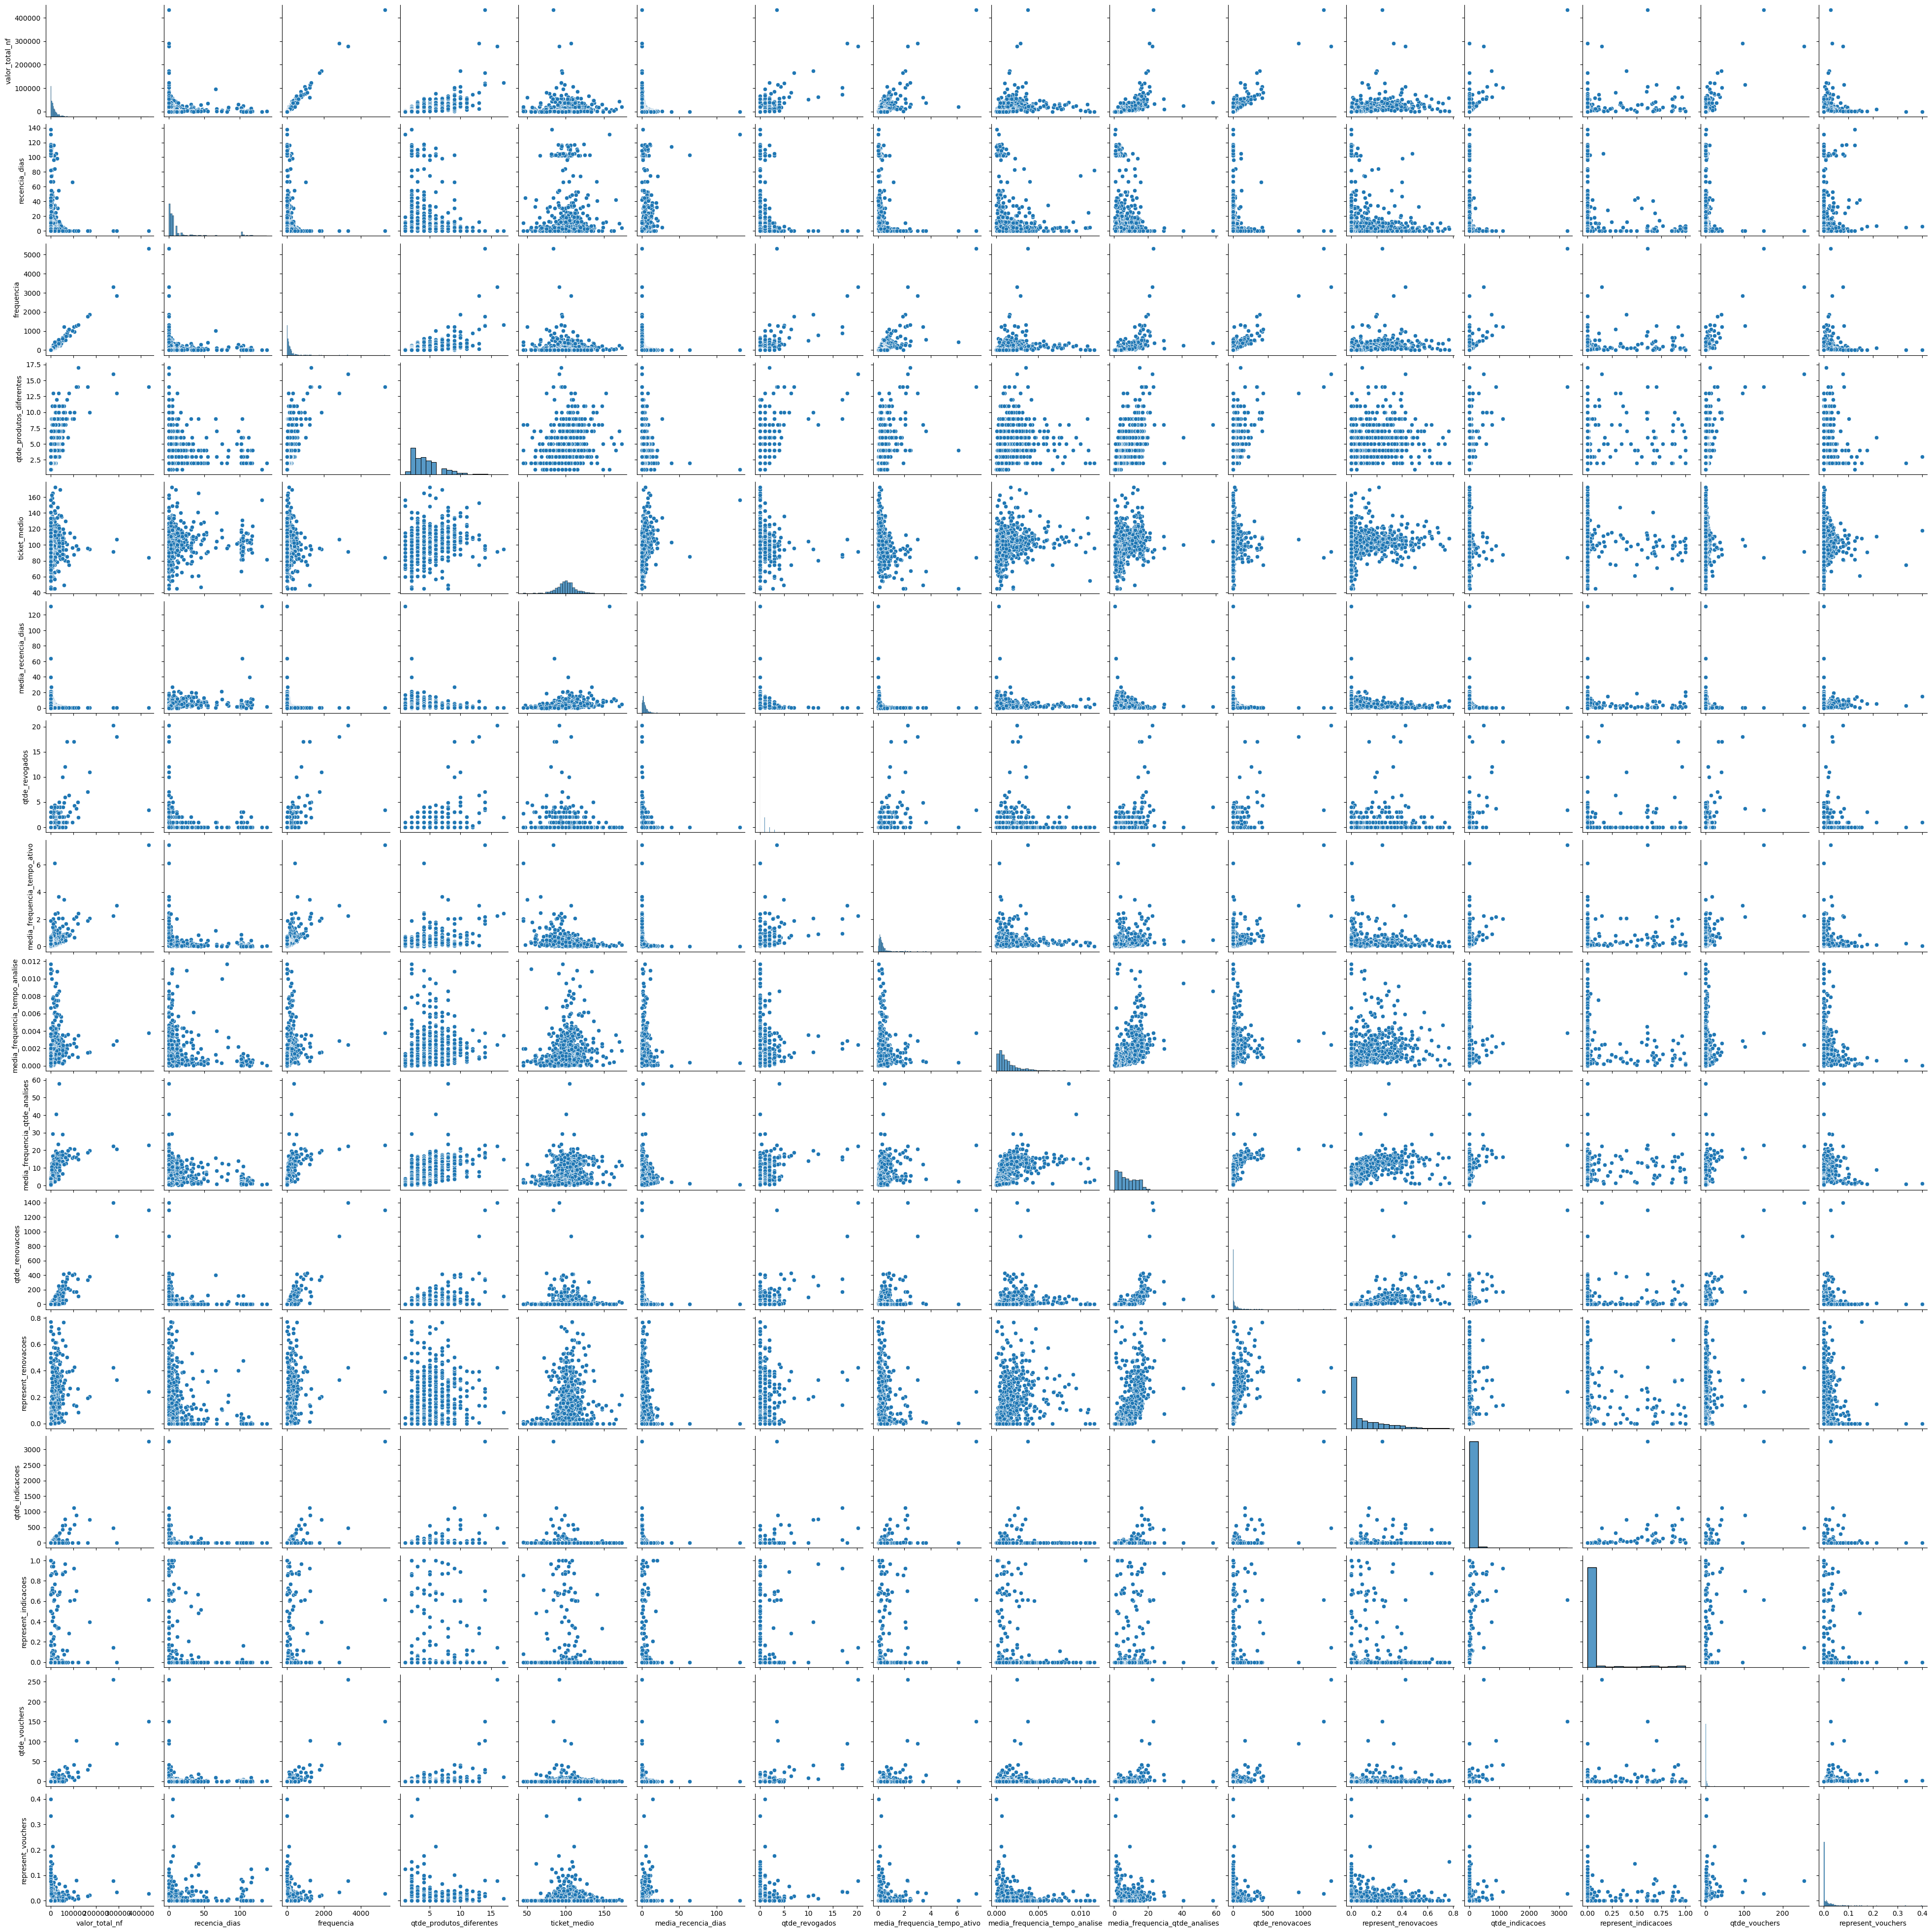

In [45]:
plt.figure(figsize=[25, 12])
sns.pairplot(df4.drop('empresa_unidade', axis=1));

## 4.3 - Estudo de espaço

In [46]:
df4_aux = df4.copy()

In [47]:
mms = pp.MinMaxScaler()

for i in df4_aux.columns[1:]:
    df4_aux[i] = mms.fit_transform(df4_aux[[i]])

In [48]:
X = df4_aux.drop('empresa_unidade', axis=1)

### 4.3.1 - PCA

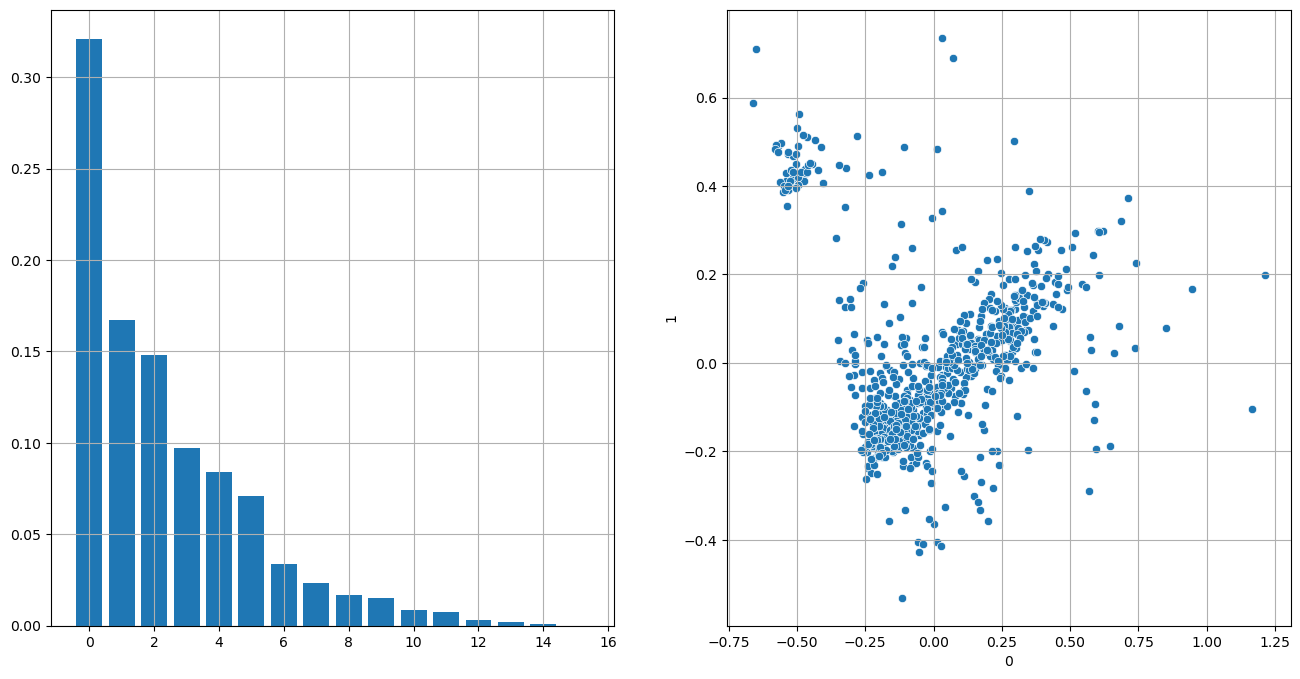

In [49]:
pca = dd.PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

# Plot explained variable
features = range(pca.n_components_)
plt.figure(figsize=[16, 8])
plt.subplot(1, 2, 1)
plt.bar(features, pca.explained_variance_ratio_)
plt.grid()

# PCA component
df_pca = pd.DataFrame(principal_components)

# Dispersão em 2D
plt.subplot(1, 2, 2)
sns.scatterplot(x=0, y=1, data=df_pca)
plt.grid();

### 4.3.2 - UMAP

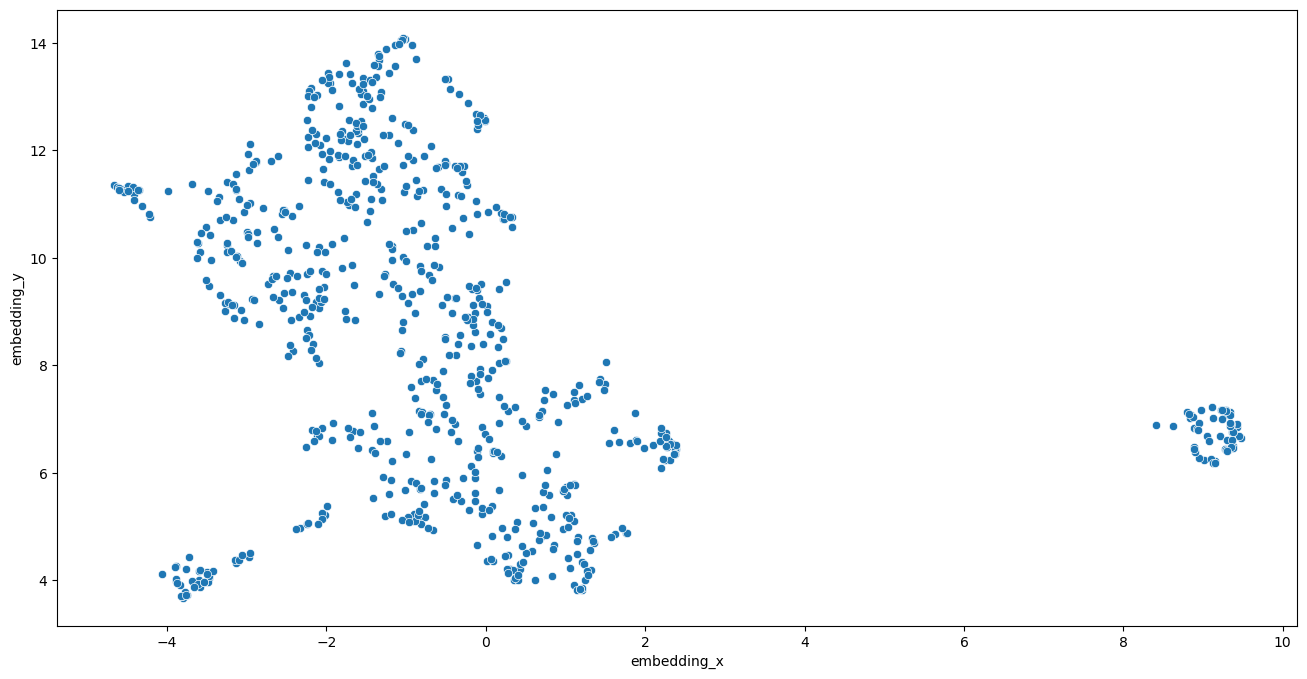

In [50]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 4.3.3 - t-SNE

C:\Users\faust\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\faust\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


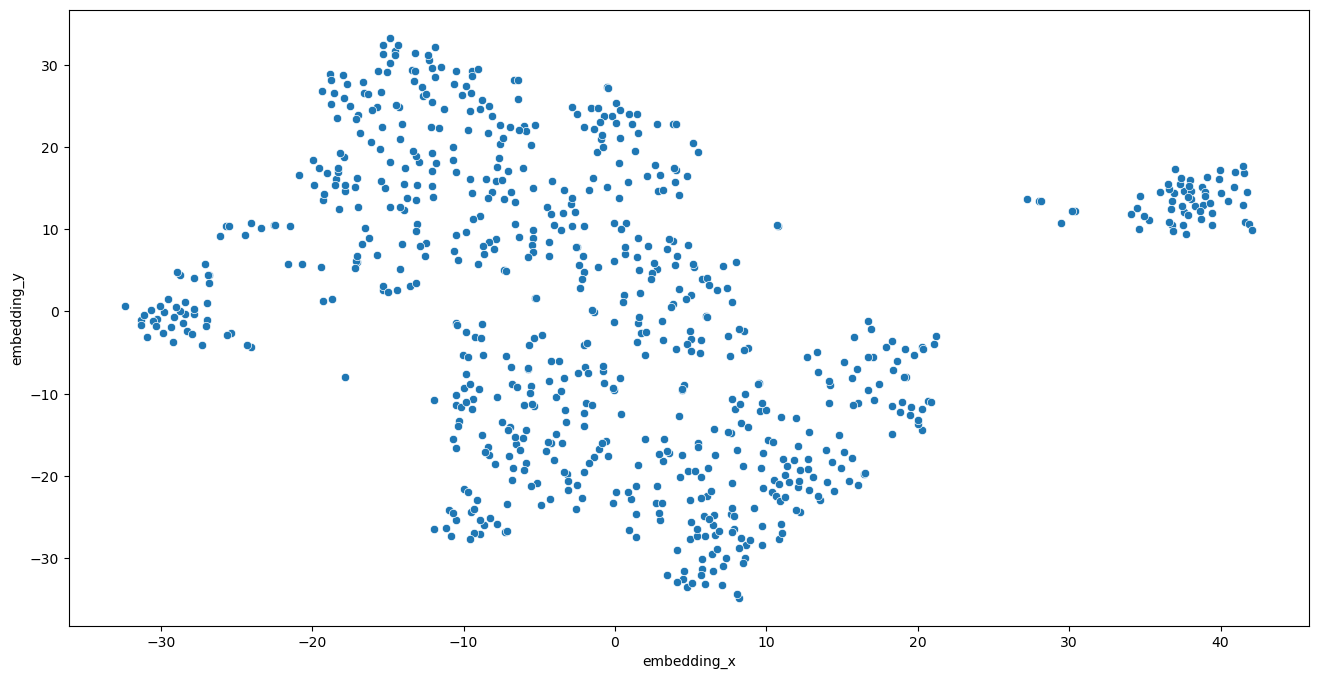

In [51]:
reducer = mn(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot t-SNE
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 4.3.3 - Tree-Based Embedding

In [52]:
# Training dataset
X = df4_aux.drop(['empresa_unidade', 'valor_total_nf'], axis=1)
y = df4_aux['valor_total_nf']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

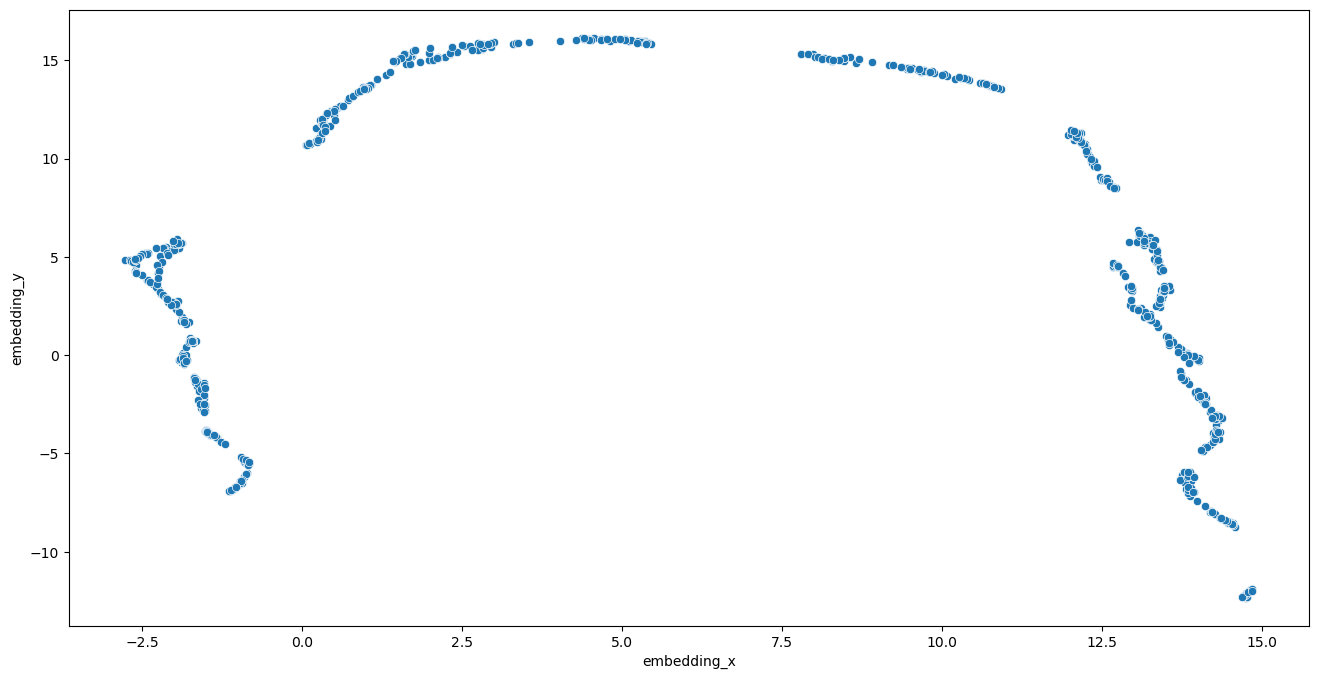

In [53]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 5 - PREPARAÇÃO DOS DADOS

In [54]:
df5 = df4.copy()

In [55]:
# Aplicando MinMaxScaler
mms = pp.MinMaxScaler()

for i in df5.columns[1:]:
    df5[i] = mms.fit_transform(df5[[i]])

# 6 - SELEÇÃO DE FEATURES

In [56]:
df6 = df5.copy()

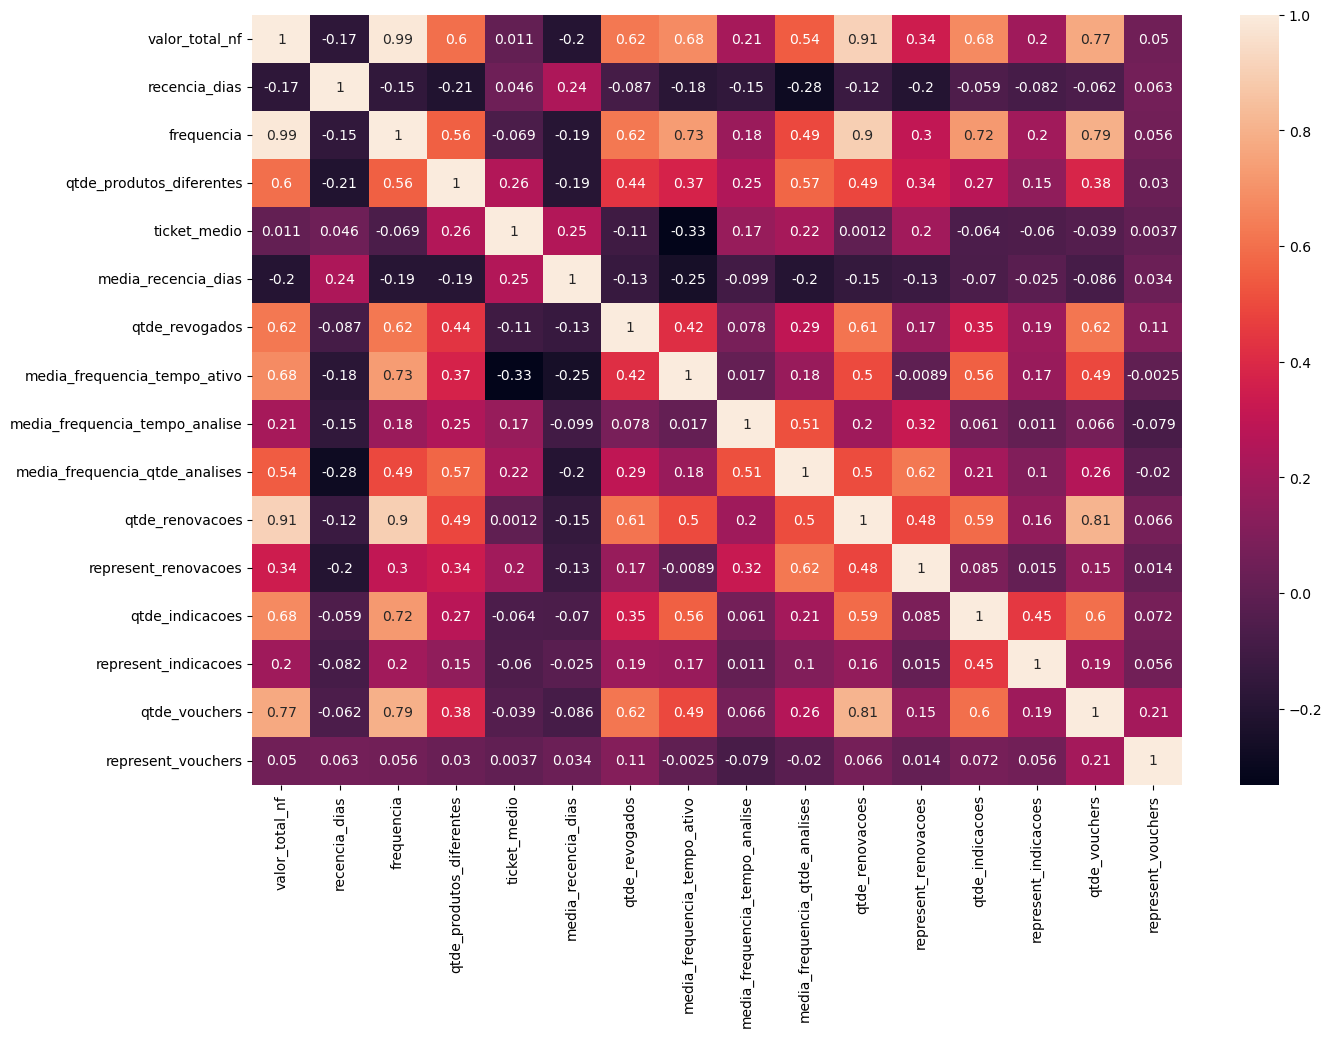

In [57]:
plt.figure(figsize=(15,10))
correlation = df6.drop('empresa_unidade', axis=1).corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [58]:
cols_not_selected = ['represent_vouchers', 'represent_indicacoes', 'media_frequencia_tempo_analise', 'media_recencia_dias', 
                     'ticket_medio', 'recencia_dias']
    
cols_selected = [i for i in df6.columns if i not in cols_not_selected]
cols_selected

['empresa_unidade',
 'valor_total_nf',
 'frequencia',
 'qtde_produtos_diferentes',
 'qtde_revogados',
 'media_frequencia_tempo_ativo',
 'media_frequencia_qtde_analises',
 'qtde_renovacoes',
 'represent_renovacoes',
 'qtde_indicacoes',
 'qtde_vouchers']

In [59]:
df6 = df6.loc[:, cols_selected]

# 7 - MODELOS DE MACHINE LEARNING

## 7.1 - Hyperparameter Fine Tuning of Tree-based Embedding

O objetivo da aplicação do **hyperparameter fine tuning** é encontrar a melhor separação dos clusters via UMAP. Por análises anteriores, o que mais influencia a separação dos clusters é o parâmetro **n_estimators**. Os outros pouco influenciam ou não promovem a separação.

**n_estimators** mais espaçados de 100 a 1000

### n_estimators de 100 a 1000

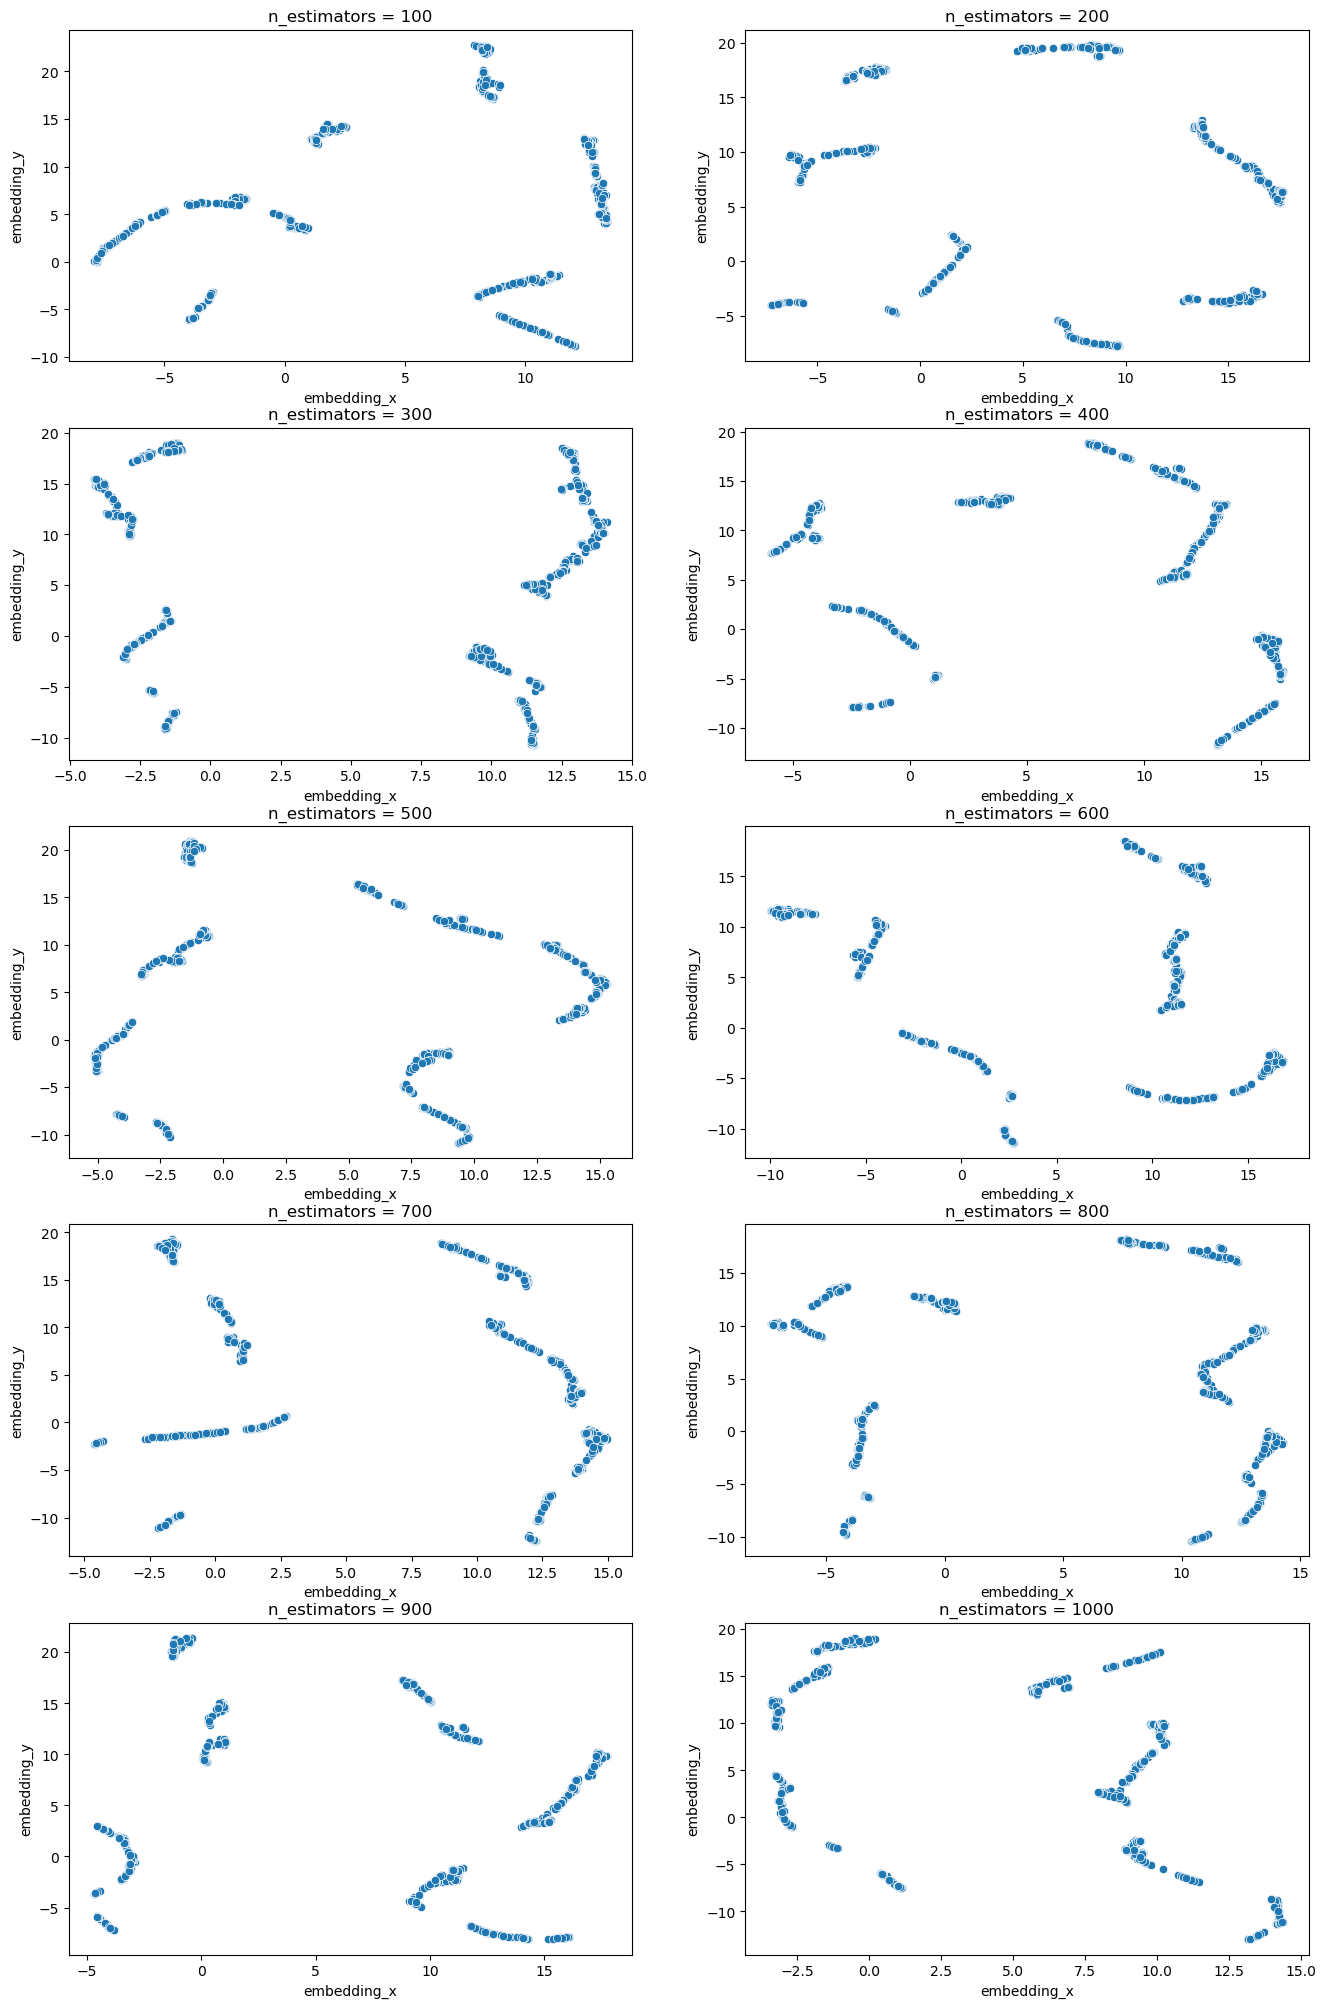

In [60]:
# Training dataset
X = df6.drop(['empresa_unidade', 'valor_total_nf'], axis=1)
y = df6['valor_total_nf']
plt.figure(figsize=[16, 25])

for i in range(100, 1100, 100):
    # model definition
    rf_model = en.RandomForestRegressor(n_estimators=i, random_state=42, max_samples=None, max_depth=100)
    
    # model training
    rf_model.fit(X, y)
    
    # Leaf
    df_leaf = pd.DataFrame(rf_model.apply(X))
    
    # reducer using umap
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(df_leaf)
    
    # embedding
    df_tree = pd.DataFrame()
    df_tree['embedding_x'] = embedding[:, 0]
    df_tree['embedding_y'] = embedding[:, 1]
    
    # plot UMAP
    plt.subplot(5, 2, int(i/100))
    plt.title('n_estimators = {}'.format(i))
    sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

### Análise em torno de n_estimators = 200

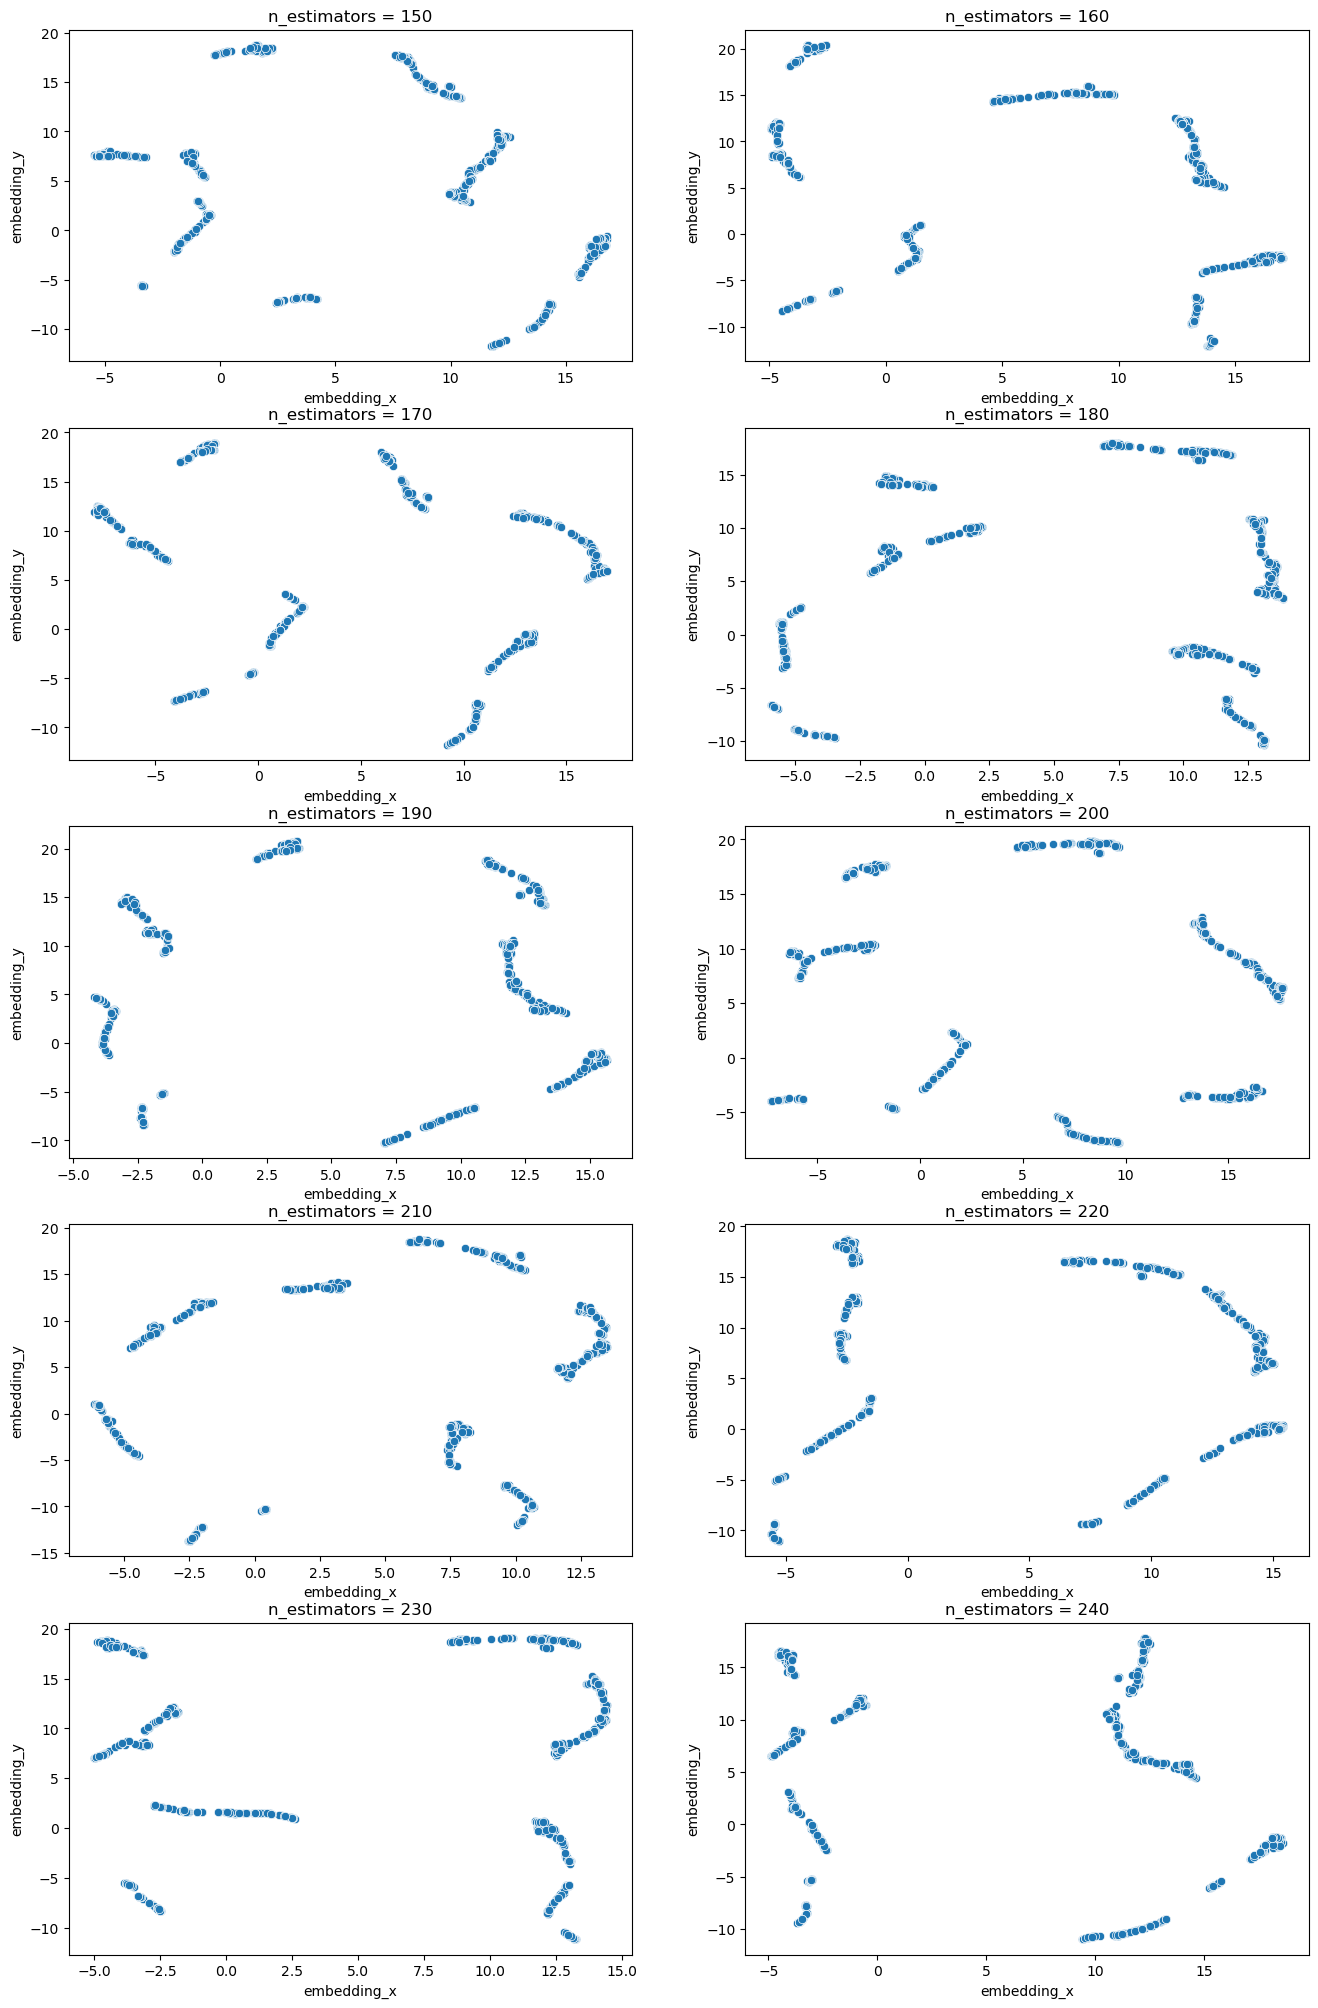

In [61]:
# Training dataset
X = df6.drop(['empresa_unidade', 'valor_total_nf'], axis=1)
y = df6['valor_total_nf']
plt.figure(figsize=[16, 25])

for i in range(150, 250, 10):
    # model definition
    rf_model = en.RandomForestRegressor(n_estimators=i, random_state=42, max_samples=None, max_depth=100)
    
    # model training
    rf_model.fit(X, y)
    
    # Leaf
    df_leaf = pd.DataFrame(rf_model.apply(X))
    
    # reducer using umap
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(df_leaf)
    
    # embedding
    df_tree = pd.DataFrame()
    df_tree['embedding_x'] = embedding[:, 0]
    df_tree['embedding_y'] = embedding[:, 1]
    
    # plot UMAP
    plt.subplot(5, 2, int(i/10-14))
    plt.title('n_estimators = {}'.format(i))
    sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

### n_estimators escolhido: 190

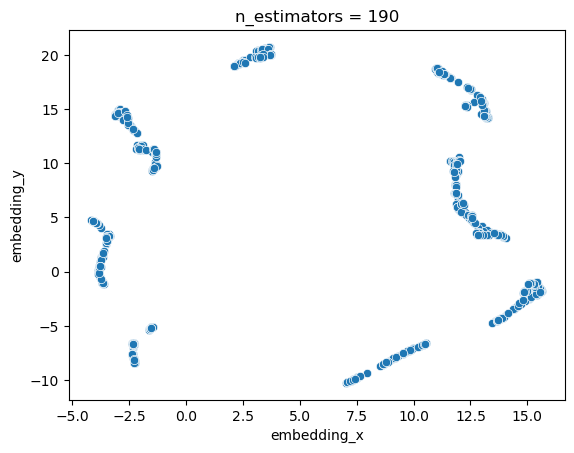

In [62]:
# model definition
rf_model = en.RandomForestRegressor(n_estimators=190, random_state=42, max_samples=None, max_depth=100)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

# reducer using umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.title('n_estimators = 190')
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

In [63]:
# Dataset Embedding
X = df_tree.copy()

## 7.2 - K-Means

In [64]:
# Clusters
clusters = np.arange(2, 25).tolist()

In [65]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k, n_init=300, random_state=42)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

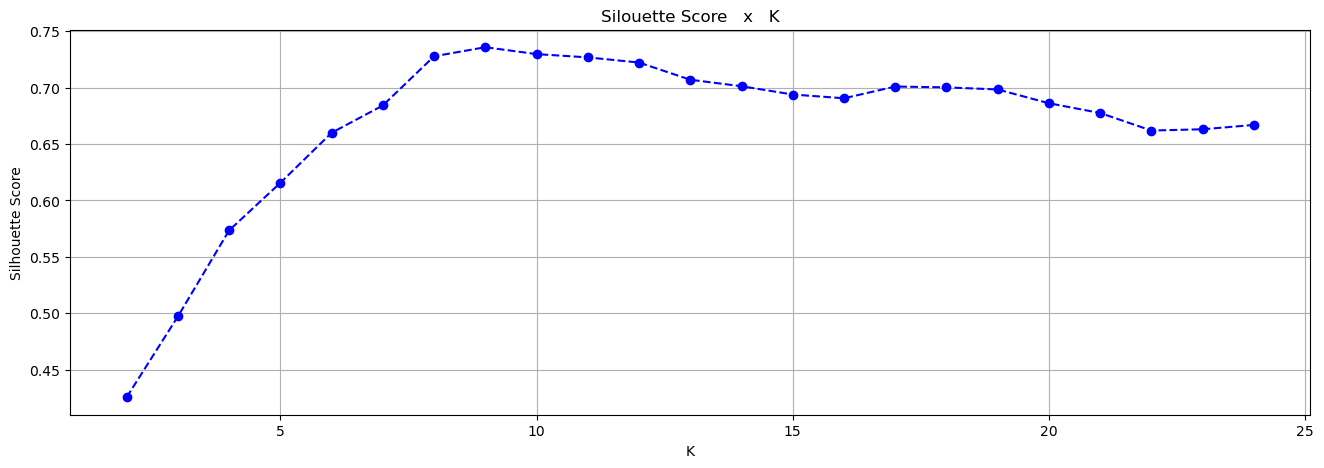

In [66]:
plt.figure(figsize=[16,5])
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K')
plt.grid();

## 7.3 - Gaussian Mixture Model (GMM)

In [67]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=300, covariance_type='full', random_state=42)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

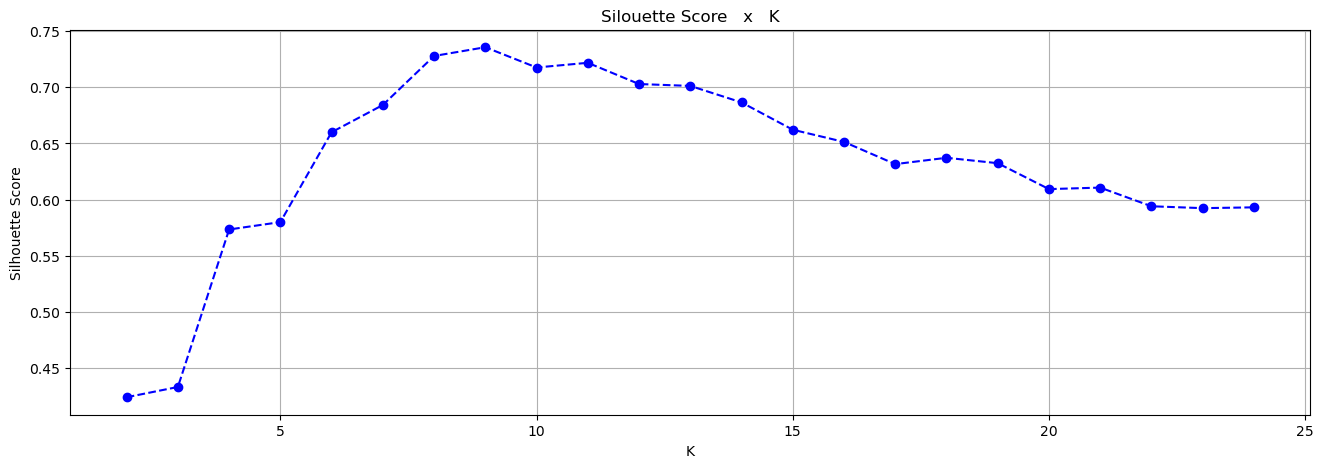

In [68]:
plt.figure(figsize=[16,5])
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K')
plt.grid();

## 7.4 - Hierarchial clustering

In [69]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

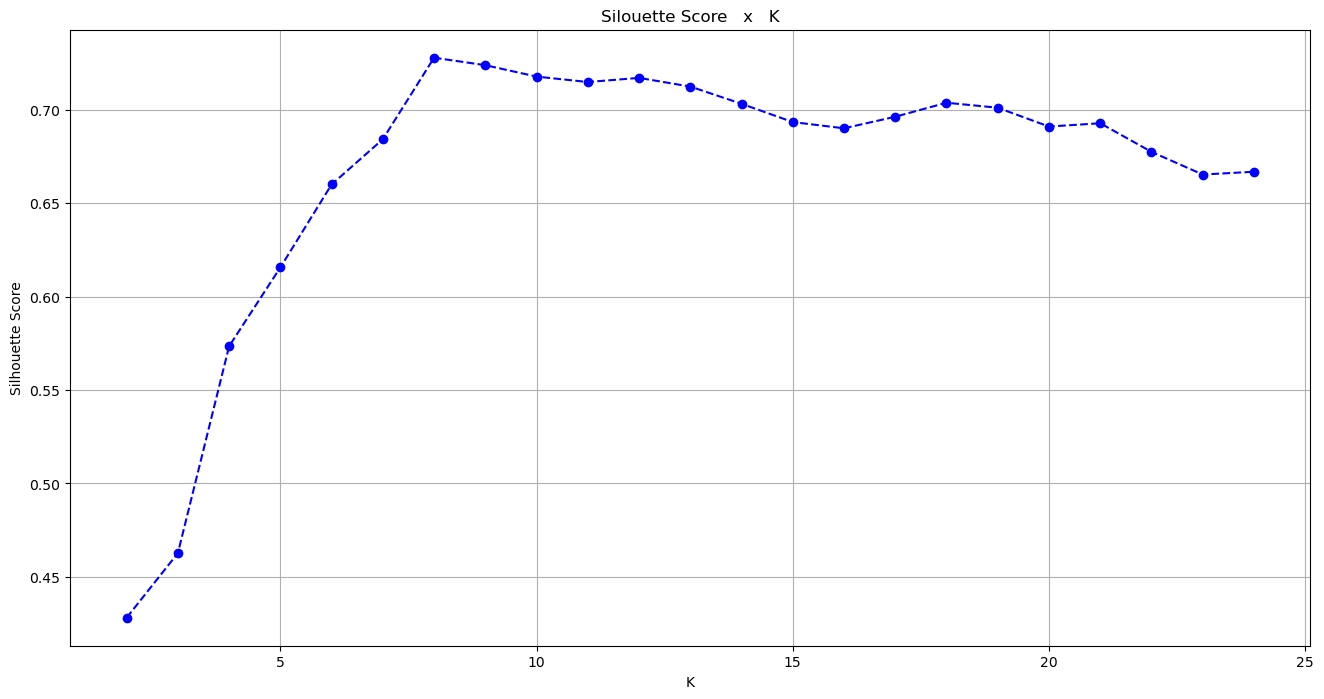

In [70]:
plt.figure(figsize=[16,8])
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K')
plt.grid();

## 7.5 - DBSCAN

In [71]:
dbs_list = []
dbs_df = []
eps_test = np.arange(100, 250, 10)
eps_test = [i/100 for i in eps_test]

for i in eps_test:
    min_samples=20
    
    # model definition
    dbscan_model = c.DBSCAN(eps=i, min_samples=min_samples)
    
    # model training and predict
    labels = dbscan_model.fit_predict(X)
    
    # metric
    sil = m.silhouette_score(X, labels, metric='euclidean')
    dbs_list.append(sil)
    
    # Dataframe
    dbs_df.append([i, sil, np.unique(labels), len(np.unique(labels))]) 

df_aux = pd.DataFrame(dbs_df, columns=['eps', 'ss_value', 'labels', 'k'])
df_aux

eps  ss_value                              labels   k
0   1.0  0.699157  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  11
1   1.1  0.710655     [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]  10
2   1.2  0.716316        [-1, 0, 1, 2, 3, 4, 5, 6, 7]   9
3   1.3  0.716316        [-1, 0, 1, 2, 3, 4, 5, 6, 7]   9
4   1.4  0.713155        [-1, 0, 1, 2, 3, 4, 5, 6, 7]   9
5   1.5  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
6   1.6  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
7   1.7  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
8   1.8  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
9   1.9  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
10  2.0  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
11  2.1  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
12  2.2  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
13  2.3  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8
14  2.4  0.727897            [0, 1, 2, 3, 4, 5, 6, 7]   8

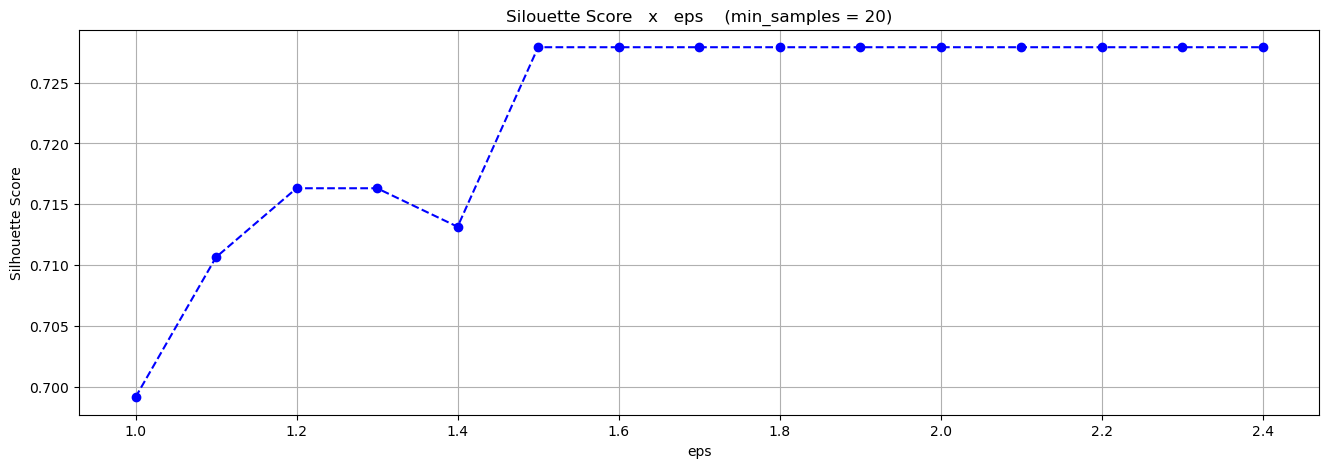

In [72]:
plt.figure(figsize=[16,5])
plt.plot(eps_test, dbs_list, linestyle='--', marker='o', color='b')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   eps    (min_samples = 20)')
plt.grid();

## 7.6 - Results

In [73]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM':       gmm_list,
     'HC':         hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

In [74]:
# DB Scan
df_aux = df_aux.loc[:, ['eps', 'k', 'ss_value']]
df_aux['k'] = df_aux['k'].astype(int)
df_aux = df_aux.set_index('eps').T
df_aux.style.highlight_max(color='lightgreen', axis=1)

# 8 - ANÁLISE DOS CLUSTERS

In [75]:
# Número de clusters selecionado
k = 8

O número de clusters acima **foi escolhido** pois é um valor mais baixo (traz maior facilidade de trabalho ao setor de pós-venda com um nº menor de classificações), interessante com um bom valor de Silhouette Score.

## 8.1 - Modelos com o k selecionado

### 8.1.1 - K-Means

In [76]:
# KMeans
# mode definition
kmeans = c.KMeans(init='random', n_clusters=k, n_init=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels_kmeans = kmeans.labels_

In [77]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# Silhouette Score
print('SS value: {}'.format(m.silhouette_score(X, labels_kmeans, metric='euclidean')))

WSS value: 2646.0537109375
SS value: 0.7278971672058105


In [78]:
df8_kmeans = X.copy()
df8_kmeans['cluster'] = labels_kmeans
df8_kmeans.head()

embedding_x  embedding_y  cluster
0    11.991322     5.743211        6
1    13.857198    -4.321723        5
2     7.130026   -10.175261        4
3    11.937620     6.190558        6
4    14.716562    -2.764965        5

### 8.1.2 - GMM

In [79]:
# GMM
# model definition
gmm = mx.GaussianMixture(n_components=k, n_init=300, covariance_type='full', random_state=42)

# model training
gmm.fit(X)

# model predict
labels_gmm = gmm.predict(X)

In [80]:
# Silhouette Score
print('SS value: {}'.format(m.silhouette_score(X, labels_gmm, metric='euclidean')))

SS value: 0.7278971672058105


In [81]:
df8_gmm = X.copy()
df8_gmm['cluster'] = labels_gmm
df8_gmm.head()

embedding_x  embedding_y  cluster
0    11.991322     5.743211        3
1    13.857198    -4.321723        0
2     7.130026   -10.175261        4
3    11.937620     6.190558        3
4    14.716562    -2.764965        0

### 8.1.3 - HC

In [82]:
# HC
# model definition and training
hcm = hc.linkage(X, 'ward')

# model predict
labels_hc = hc.fcluster(hcm, k, criterion='maxclust')

In [83]:
# Silhouette Score
print('SS value: {}'.format(m.silhouette_score(X, labels_hc, metric='euclidean')))

SS value: 0.7278971672058105


In [84]:
df8_hc = X.copy()
df8_hc['cluster'] = labels_hc
df8_hc.head()

embedding_x  embedding_y  cluster
0    11.991322     5.743211        4
1    13.857198    -4.321723        7
2     7.130026   -10.175261        8
3    11.937620     6.190558        4
4    14.716562    -2.764965        7

### 8.1.4 - DBSCAN

In [85]:
eps=1.60
min_samples=20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels_dbs = dbscan_model.fit_predict(X)

# metric
sil = m.silhouette_score(X, labels_dbs, metric='euclidean')
print('SS value: {}'.format(sil))

SS value: 0.7278971672058105


In [86]:
df8_dbs = X.copy()
df8_dbs['cluster'] = labels_dbs
df8_dbs.head()

embedding_x  embedding_y  cluster
0    11.991322     5.743211        0
1    13.857198    -4.321723        1
2     7.130026   -10.175261        2
3    11.937620     6.190558        0
4    14.716562    -2.764965        1

## 8.2 - Visualização dos clusters

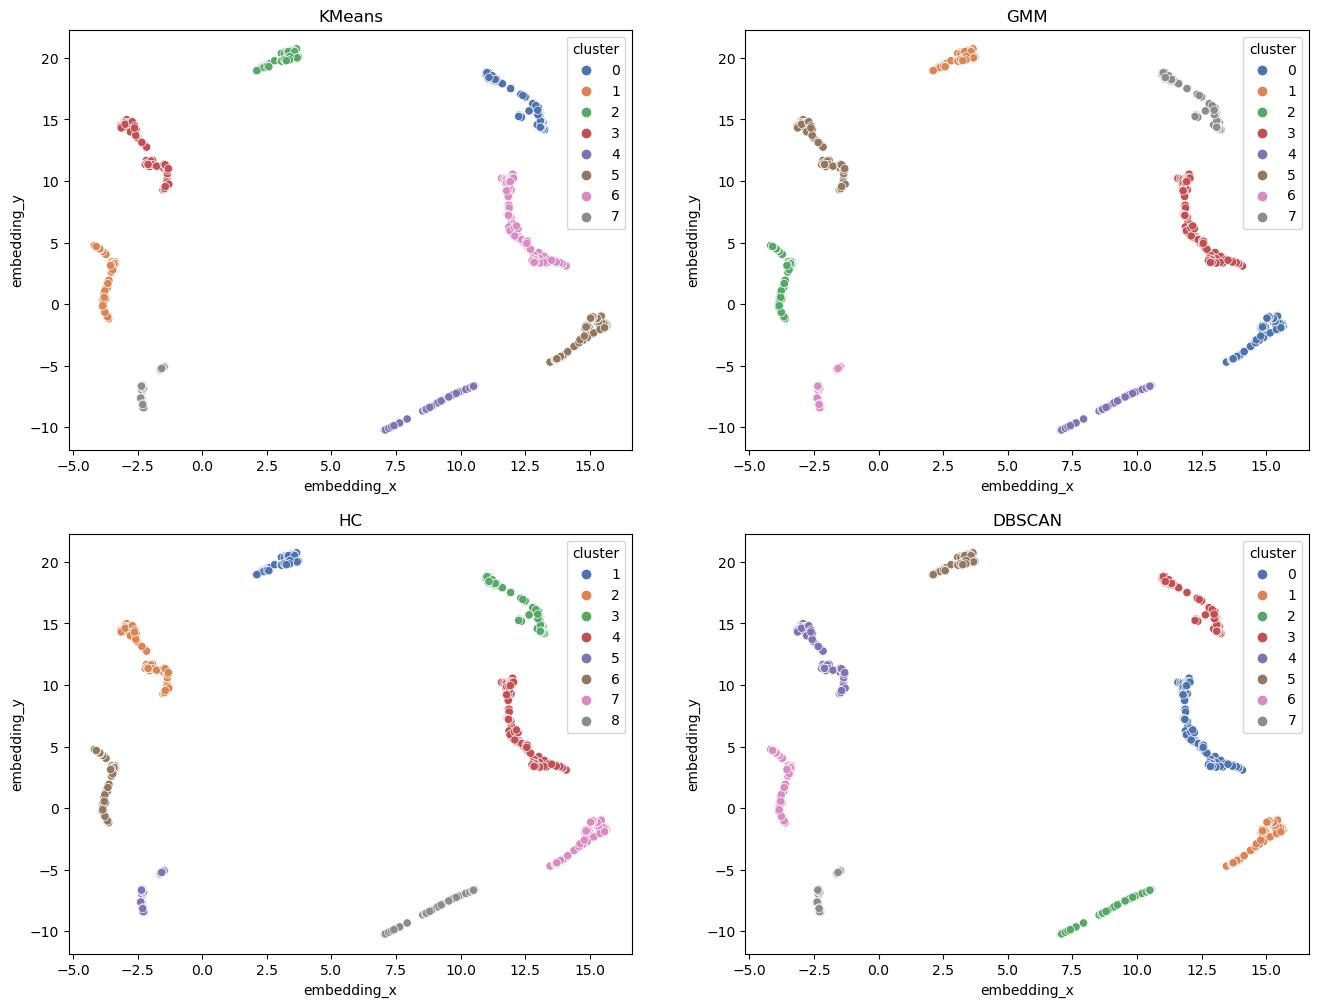

In [87]:
plt.figure(figsize=[16, 12])

# Kmeans
plt.subplot(2, 2, 1)
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df8_kmeans, palette='deep')
plt.title('KMeans')

# GM
plt.subplot(2, 2, 2)
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df8_gmm, palette='deep')
plt.title('GMM')

# HC
plt.subplot(2, 2, 3)
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df8_hc, palette='deep')
plt.title('HC')

# DBSCAN
plt.subplot(2, 2, 4)
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df8_dbs, palette='deep')
plt.title('DBSCAN');

## 8.3 - Silhouette Score Visualization

In [88]:
clusters_analysis = np.arange(2, 10).tolist()

VIsualização das silhuetas de 2 a 9 clusters.

### 8.3.1 - KMeans

For k = 2  |  Silhouette Score: 0.4255027174949646
For k = 3  |  Silhouette Score: 0.49710536003112793
For k = 4  |  Silhouette Score: 0.5734558701515198
For k = 5  |  Silhouette Score: 0.6156455278396606
For k = 6  |  Silhouette Score: 0.6600387692451477
For k = 7  |  Silhouette Score: 0.6842674612998962
For k = 8  |  Silhouette Score: 0.7278971672058105
For k = 9  |  Silhouette Score: 0.7359264492988586


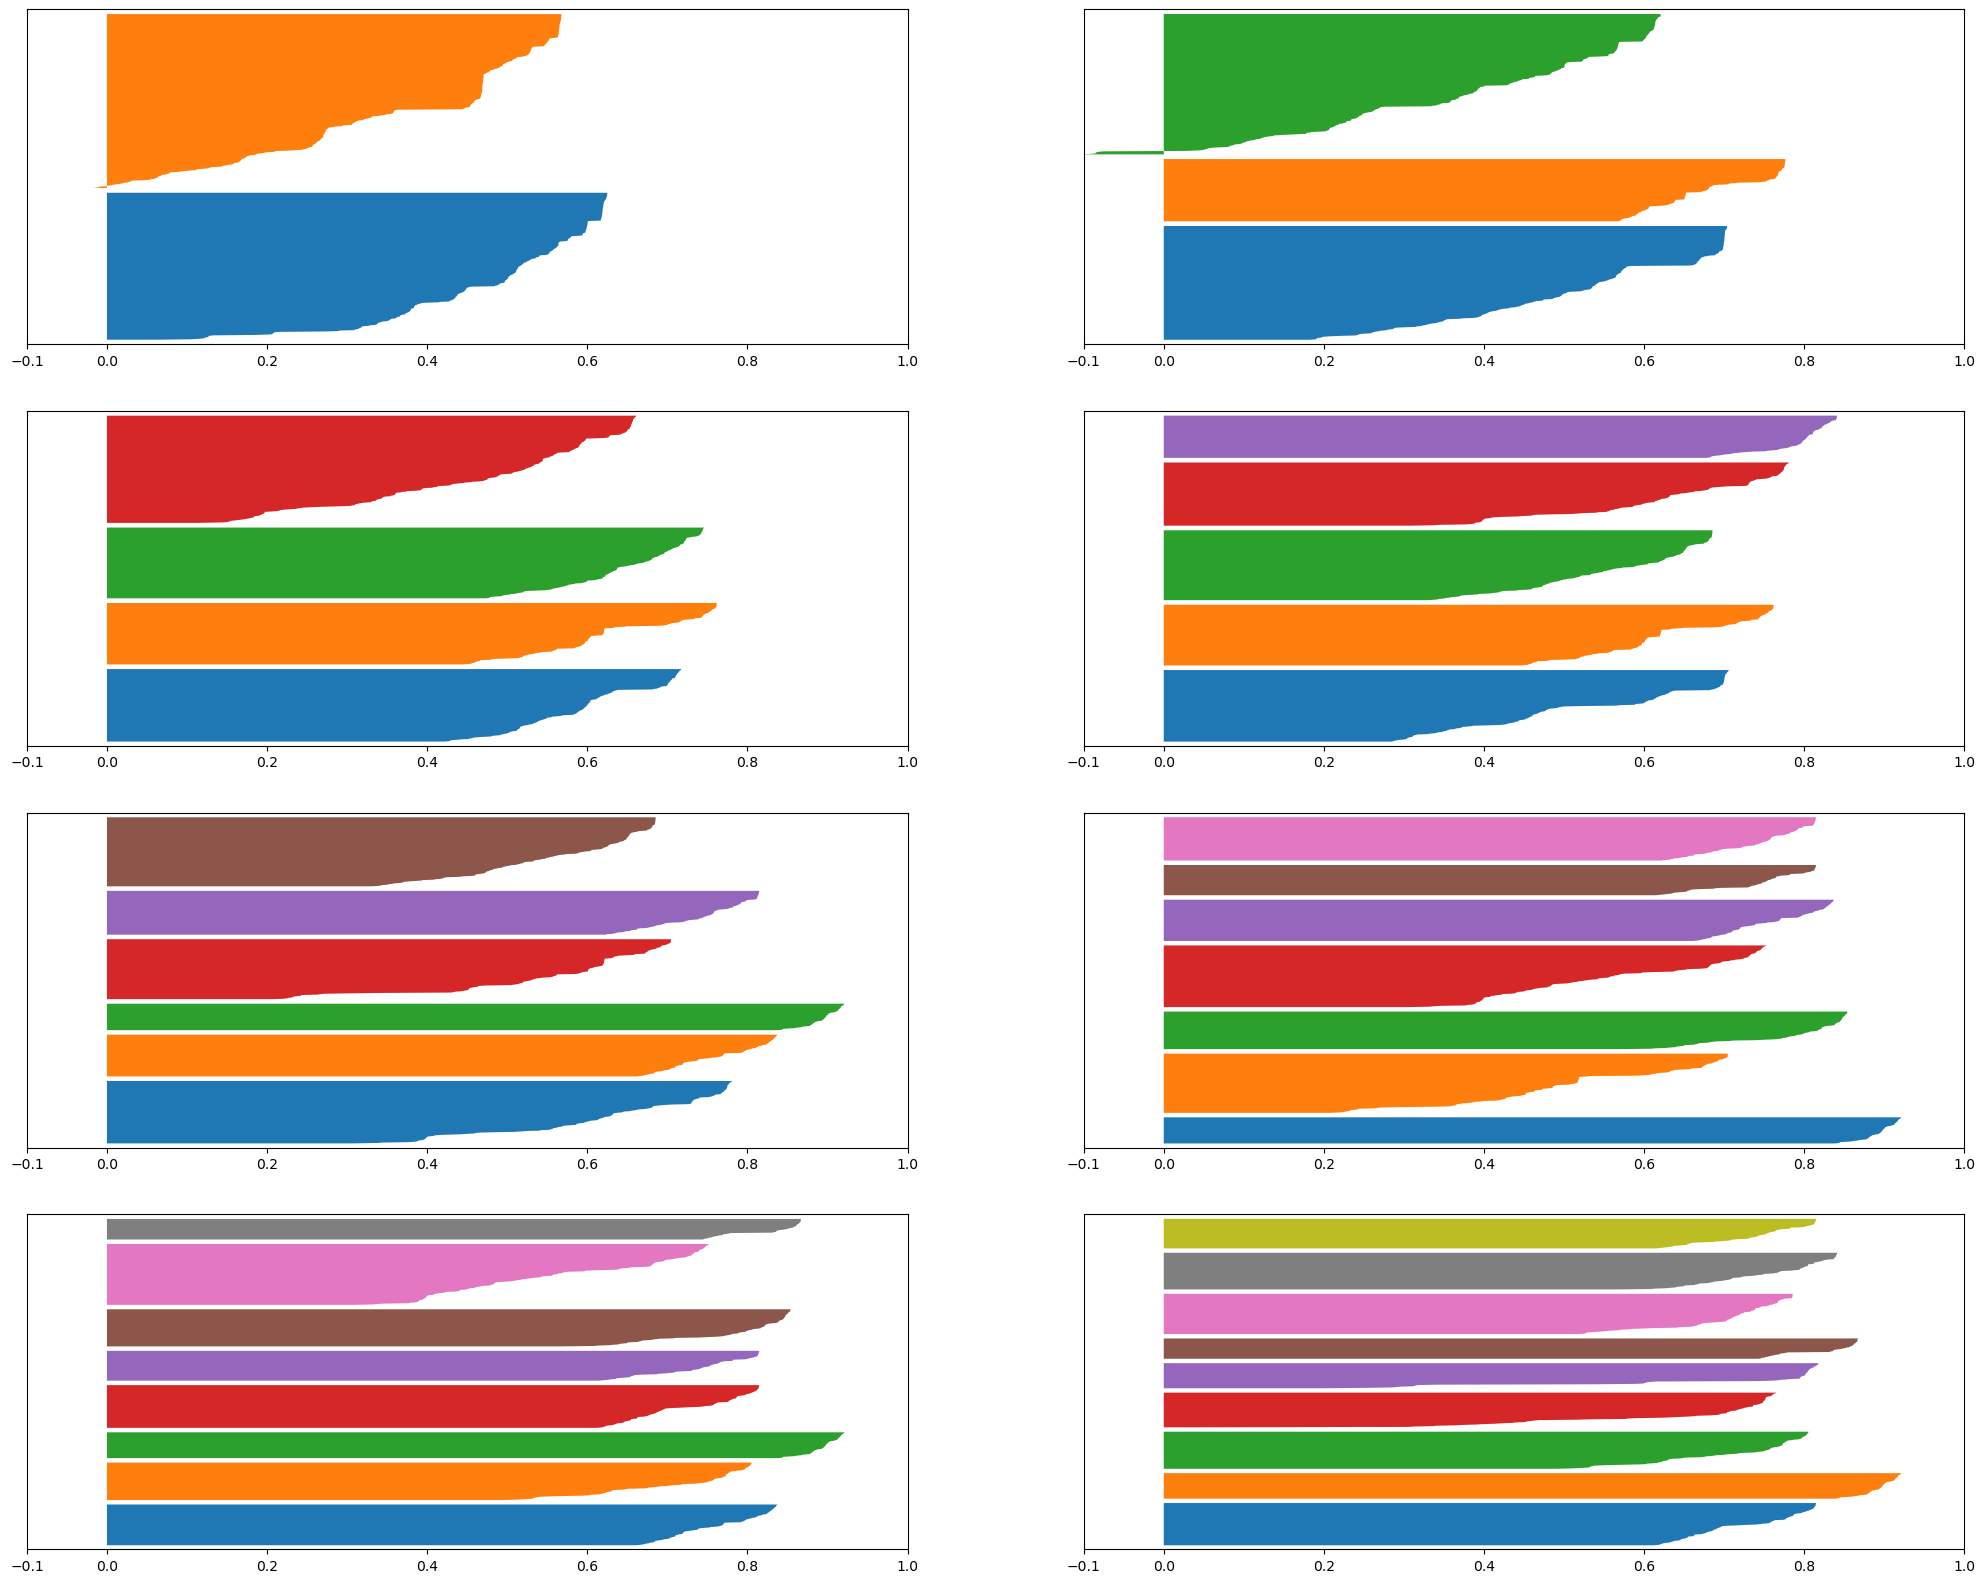

In [89]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(25, 20)

for k in clusters_analysis:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
    # mode definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=300, random_state=42)

    # model training
    kmeans.fit(X)

    # clustering
    labels = kmeans.labels_
    
    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For k = {}  |  Silhouette Score: {}'.format(k, ss))
    samples_silhouette_values = m.silhouette_samples(X, labels)
    
    y_lower = 10
    for i in range(k):  
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap('Spectral')
        color = cmap(i/k)
                
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 8.3.2 - GMM

For k = 2  |  Silhouette Score: 0.42413580417633057
For k = 3  |  Silhouette Score: 0.4332515299320221
For k = 4  |  Silhouette Score: 0.5734558701515198
For k = 5  |  Silhouette Score: 0.5800111293792725
For k = 6  |  Silhouette Score: 0.6600387692451477
For k = 7  |  Silhouette Score: 0.6842674612998962
For k = 8  |  Silhouette Score: 0.7278971672058105
For k = 9  |  Silhouette Score: 0.7356939911842346


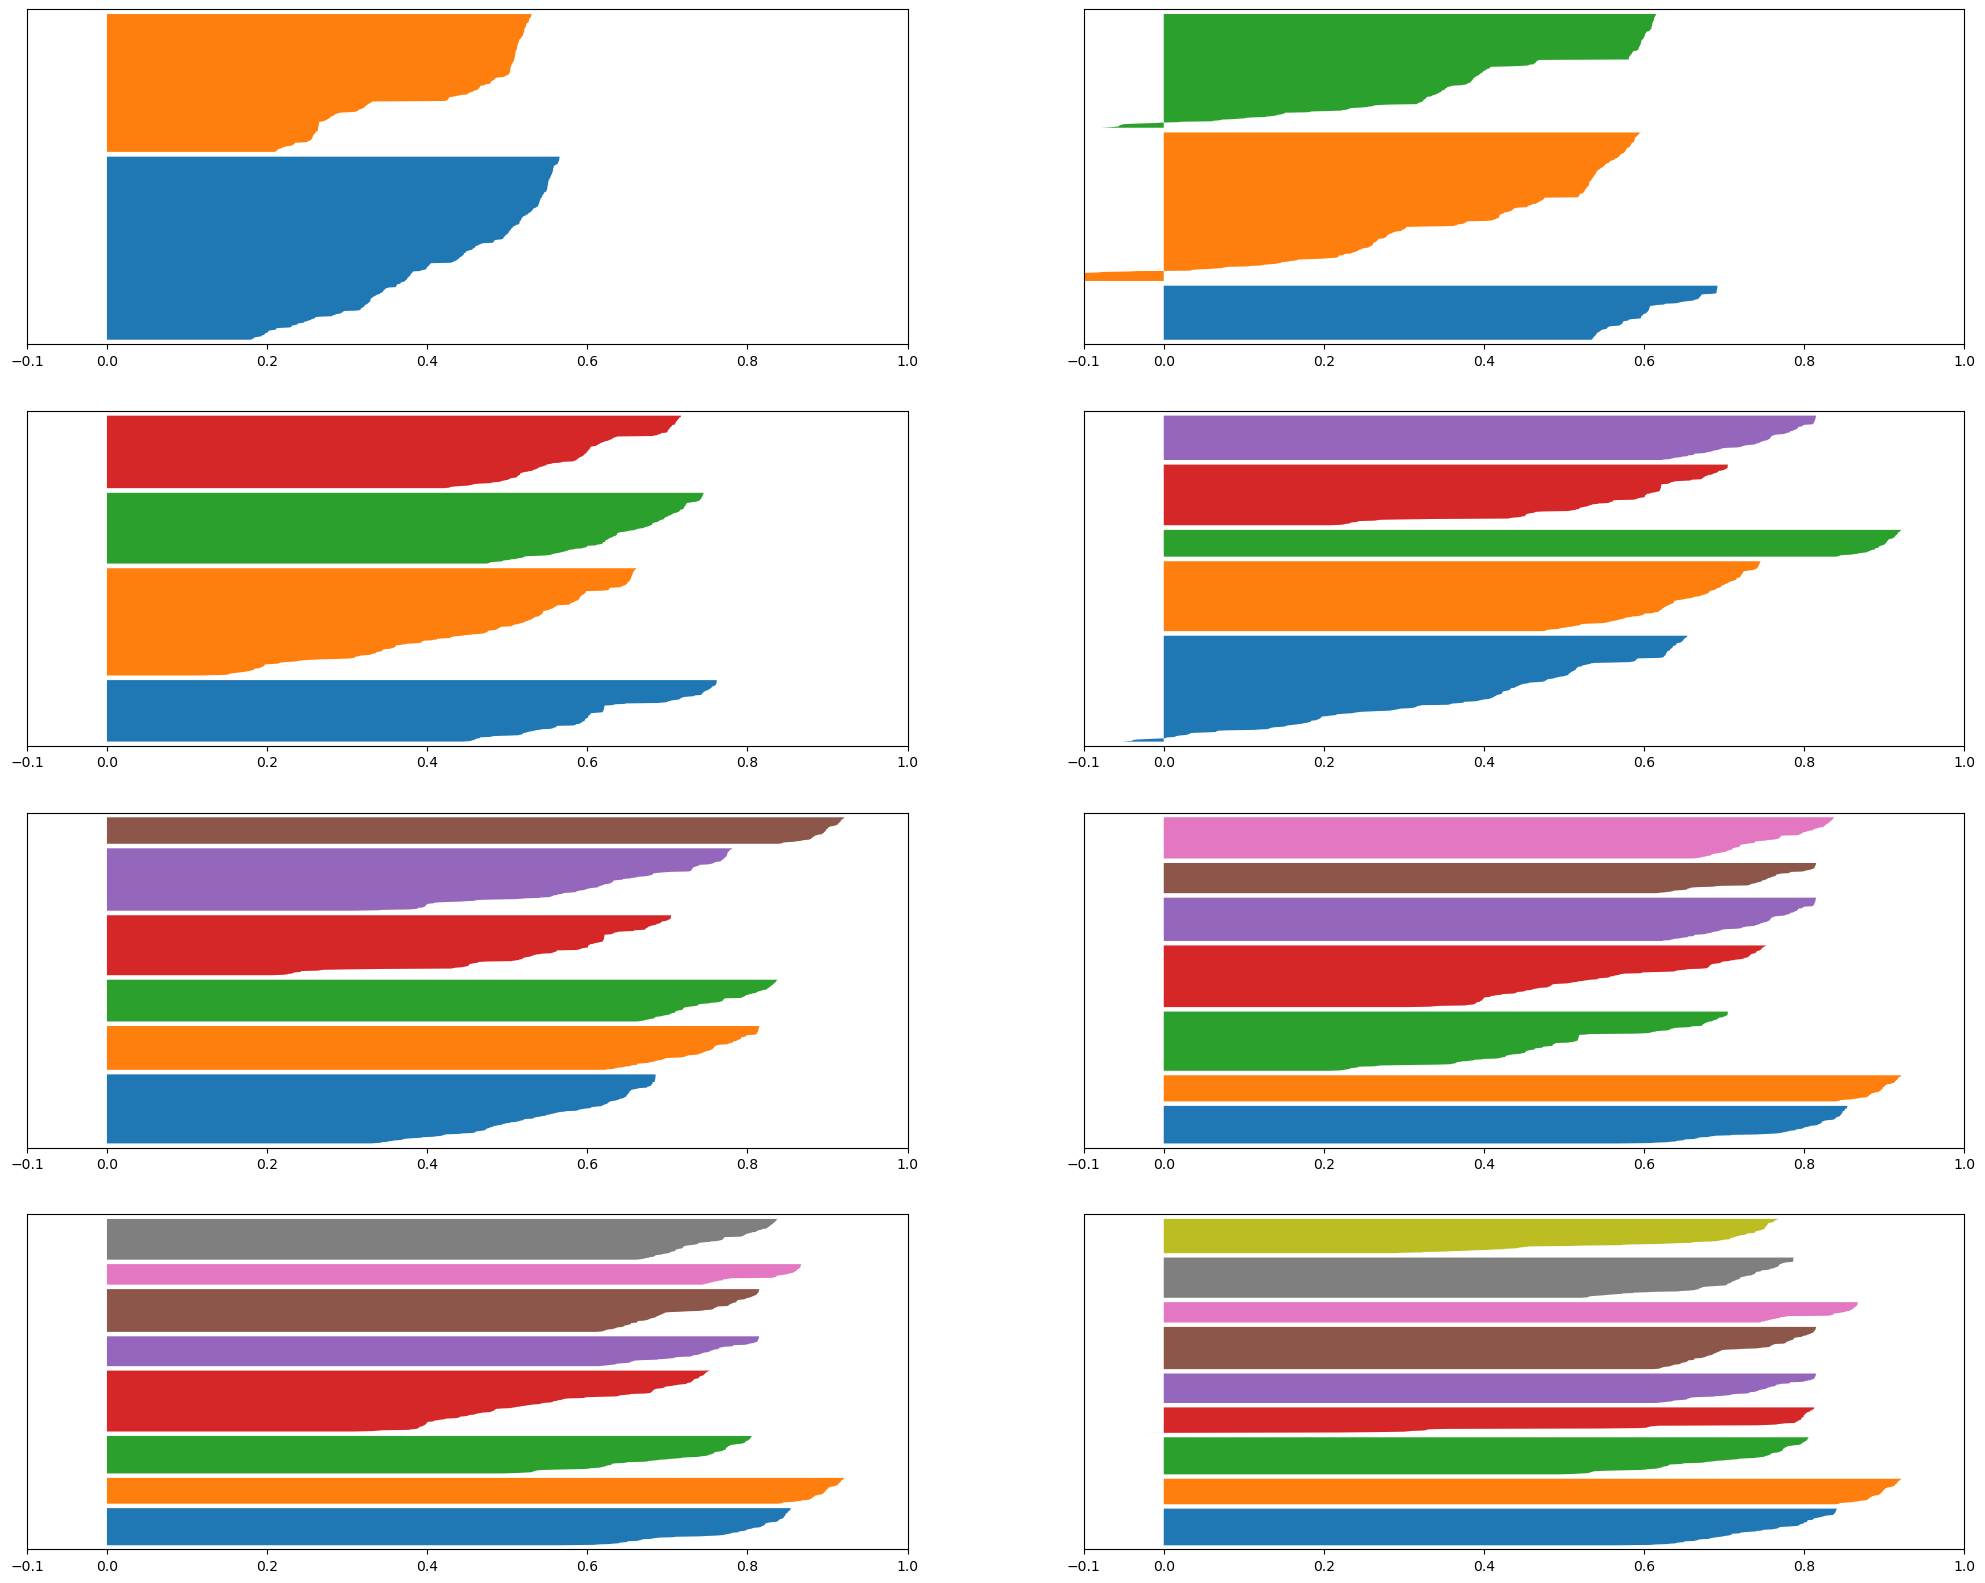

In [90]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(25, 20)

for k in clusters_analysis:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
    # model definition
    gmm = mx.GaussianMixture(n_components=k, n_init=300, covariance_type='full', random_state=42)
    
    # model training
    gmm.fit(X)
    
    # model predict
    labels = gmm.predict(X)
    
    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For k = {}  |  Silhouette Score: {}'.format(k, ss))
    samples_silhouette_values = m.silhouette_samples(X, labels)
    
    y_lower = 10
    for i in range(k):  
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap('Spectral')
        color = cmap(i/k)
                
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 8.3.3 - HC

For k = 2  |  Silhouette Score: 0.4281424880027771
For k = 3  |  Silhouette Score: 0.462717205286026
For k = 4  |  Silhouette Score: 0.5734558701515198
For k = 5  |  Silhouette Score: 0.6156455278396606
For k = 6  |  Silhouette Score: 0.6600387692451477
For k = 7  |  Silhouette Score: 0.6842674612998962
For k = 8  |  Silhouette Score: 0.7278971672058105
For k = 9  |  Silhouette Score: 0.7239051461219788


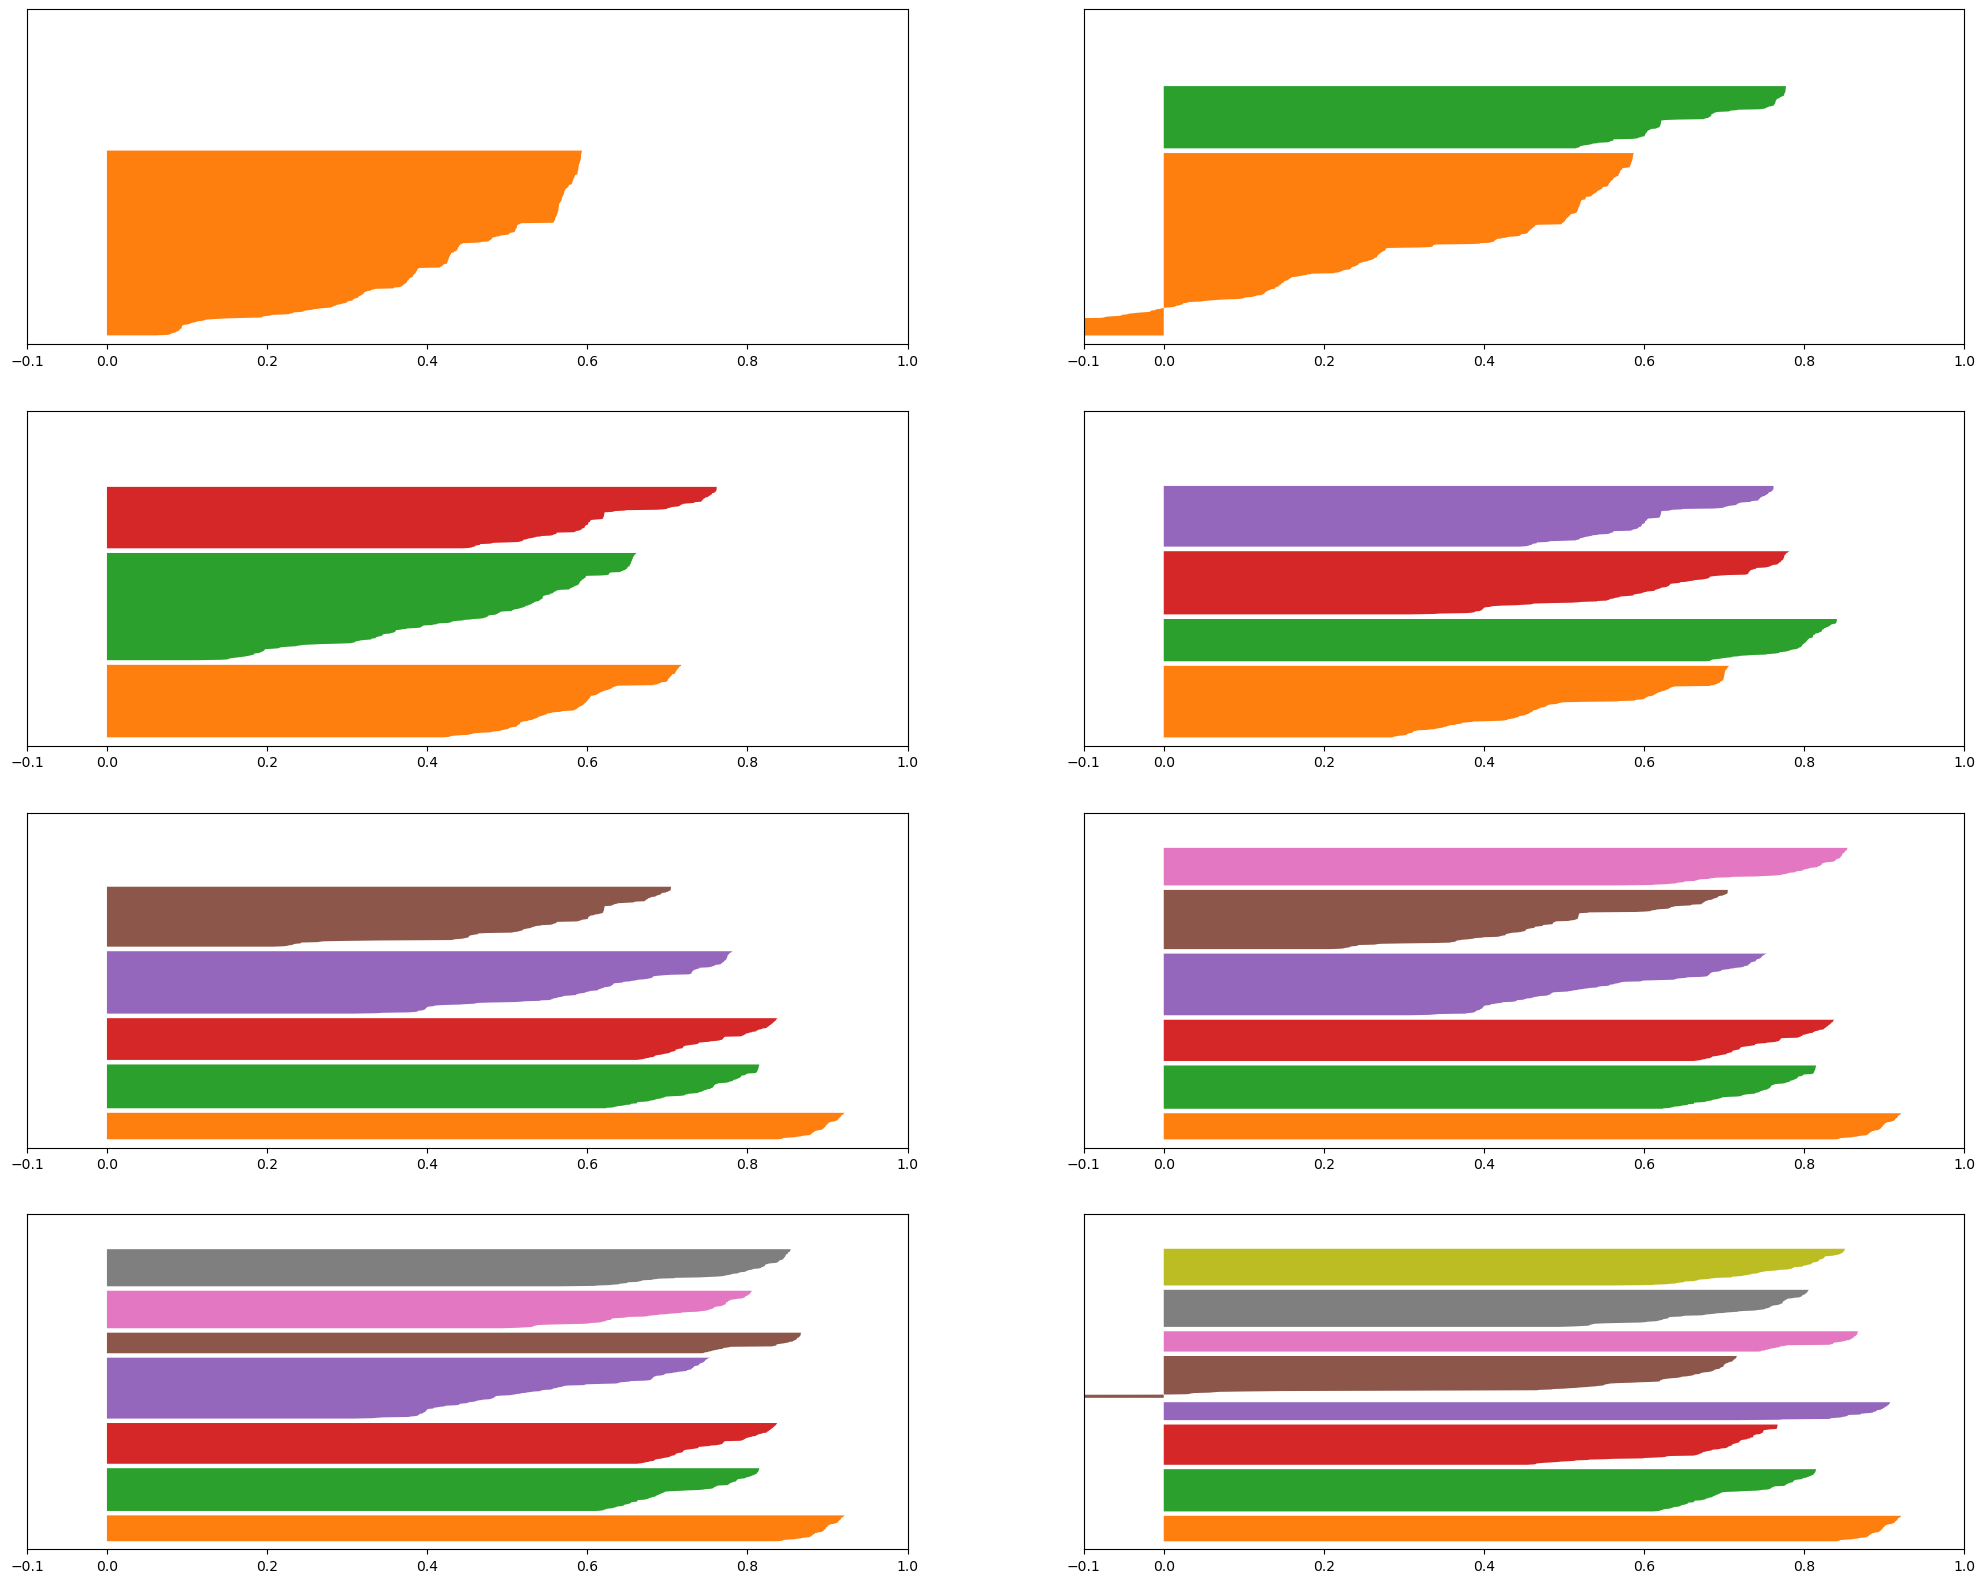

In [91]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(25, 20)

for k in clusters_analysis:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For k = {}  |  Silhouette Score: {}'.format(k, ss))
    samples_silhouette_values = m.silhouette_samples(X, labels)
    
    y_lower = 10
    for i in range(k):  
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap('Spectral')
        color = cmap(i/k)
                
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 8.3.4 - DBSCAN

For k = 2  |  Silhouette Score: 0.7278971672058105
For k = 3  |  Silhouette Score: 0.7278971672058105
For k = 4  |  Silhouette Score: 0.7278971672058105
For k = 5  |  Silhouette Score: 0.7278971672058105
For k = 6  |  Silhouette Score: 0.7278971672058105
For k = 7  |  Silhouette Score: 0.7278971672058105
For k = 8  |  Silhouette Score: 0.7278971672058105
For k = 9  |  Silhouette Score: 0.7278971672058105


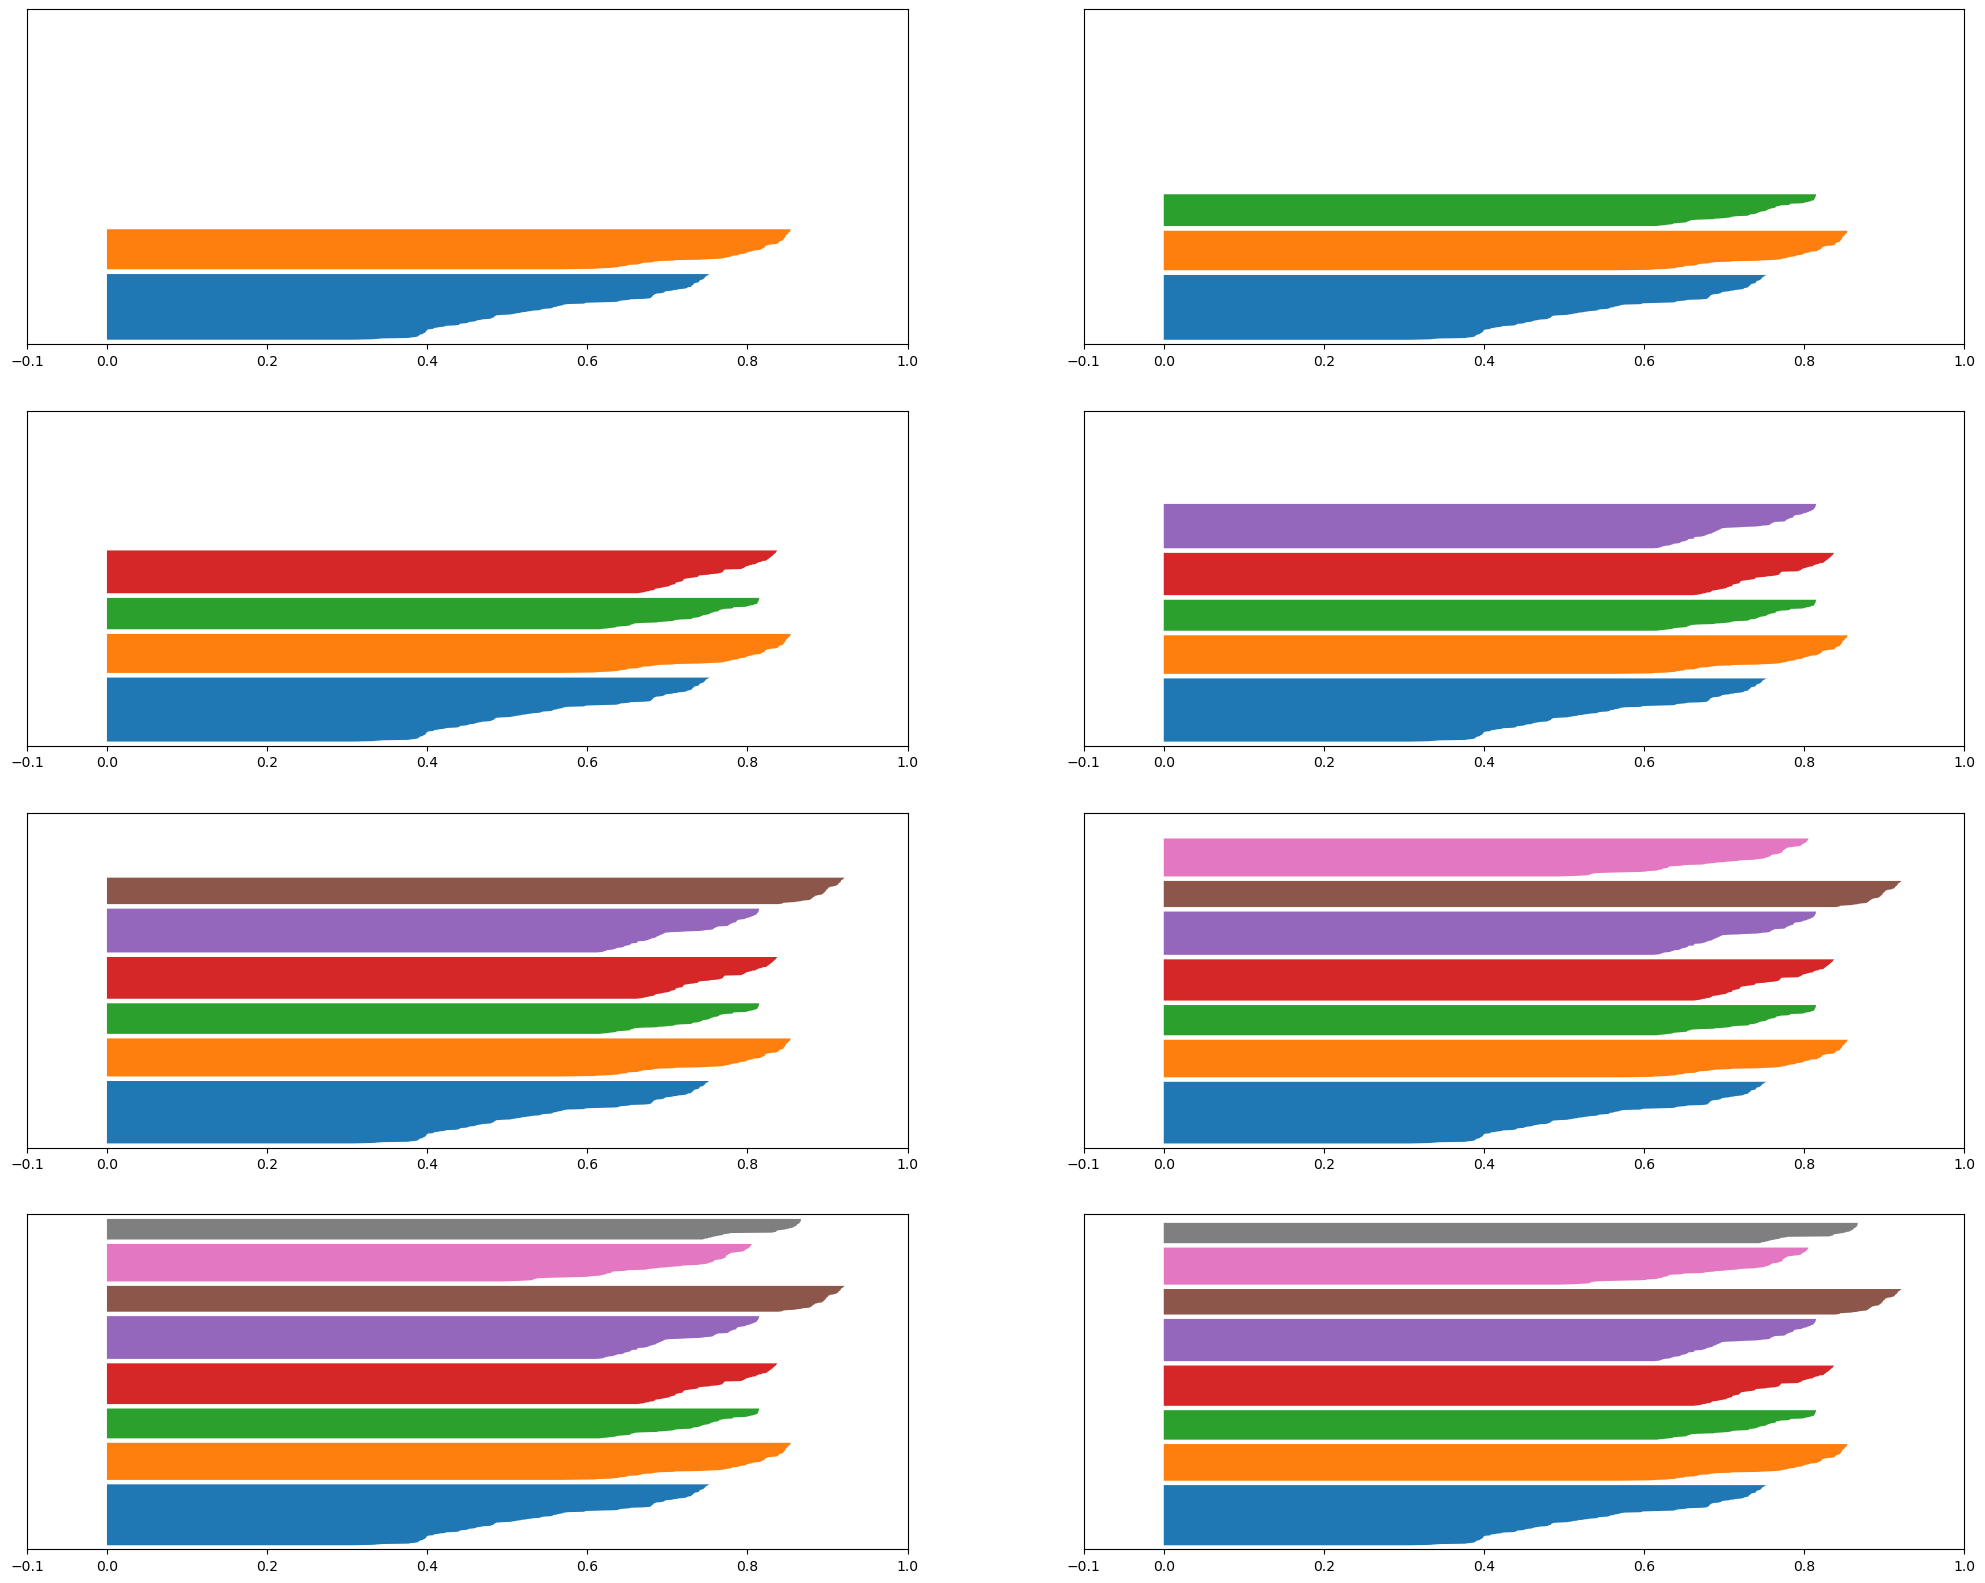

In [92]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(25, 20)

for k in clusters_analysis:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
    eps=1.60
    min_samples=20

    # model definition
    dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

    # model training and predict
    labels = dbscan_model.fit_predict(X)
    
    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For k = {}  |  Silhouette Score: {}'.format(k, ss))
    samples_silhouette_values = m.silhouette_samples(X, labels)
    
    y_lower = 10
    for i in range(k):  
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap('Spectral')
        color = cmap(i/k)
                
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## 8.4 - Modelo selecionado

Como todos os modelos apresentaram resultados e valores de métricas semelhantes, o modelo a ser selecionado será o de maior valor de Silhouette Score e mais rápido no processamento, **DBSCAN**.

# 9 - ANÁLISE DOS CLUSTERS

## 9.1 - Cluster profile

In [93]:
df9 = df4.copy()
df9['cluster'] = labels_dbs
df9.head()

empresa_unidade  valor_total_nf  recencia_dias  \
0    DIGITAL/PONTA PORA - MS / CENTRO - FABIO        15235.91              5   
1          DIGITAL/CURITIBA - PR / NOVO MUNDO        30014.36             98   
2                           DIGITAL/UNAI - MG       173045.93              0   
3    DIGITAL/CUIABA - MT - NOVA ESPERANCA III        14585.93              4   
4  DIGITAL/BELO HORIZONTE - MG / FUNCIONARIOS        43055.72             10   

   frequencia  qtde_produtos_diferentes  ticket_medio  media_recencia_dias  \
0         153                         4    100.236250             3.854305   
1         295                         7    102.438089             1.503472   
2        1871                        10     94.560617             0.174201   
3         143                         2    106.466642             4.126761   
4         255                         7    169.510709             2.388889   

   qtde_revogados  media_frequencia_tempo_ativo  \
0             1.0                      0.156442   
1             0.0                      0.242998   
2            11.0                      2.065121   
3             0.0                      0.163803   
4             0.0                      0.250491   

   media_frequencia_tempo_analise  media_frequencia_qtde_analises  \
0                        0.000950                       12.135303   
1                        0.002205                       13.859691   
2                        0.001583                       19.802470   
3                        0.001086                       13.524471   
4                        0.002762                       13.823342   

   qtde_renovacoes  represent_renovacoes  qtde_indicacoes  \
0             66.0              0.431373              0.0   
1            119.0              0.403390              0.0   
2            379.0              0.202565            742.0   
3             51.0              0.356643              0.0   
4             37.0              0.145098              0.0   

   represent_indicacoes  qtde_vouchers  represent_vouchers  cluster  
0              0.000000            1.0            0.006536        0  
1              0.000000            2.0            0.006780        1  
2              0.396579           41.0            0.021913        2  
3              0.000000            6.0            0.041958        0  
4              0.000000            1.0            0.003922        1

In [94]:
# Quantidade de unidades
df_cluster = df9[['empresa_unidade', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_unidade'] = np.round(100*df_cluster['empresa_unidade']/df_cluster['empresa_unidade'].sum(), 2).astype(str)+'%'
df_cluster = df_cluster.rename(columns={'empresa_unidade': 'qtde_unidades'})

# Média valor_total_nf
aux = df9[['valor_total_nf', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média frequencia
aux = df9[['frequencia', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média media_frequencia_tempo_ativo
aux = df9[['media_frequencia_tempo_ativo', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média recencia_dias
aux = df9[['recencia_dias', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster') 

# ticket_medio
aux = df9[['ticket_medio', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média media_recencia_dias
aux = df9[['media_recencia_dias', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média qtde_revogados
aux = df9[['qtde_revogados', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média qtde_renovacoes
aux = df9[['represent_renovacoes', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média represent_indicacoes
aux = df9[['represent_indicacoes', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média represent_vouchers
aux = df9[['represent_vouchers', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')

# Média media_frequencia_qtde_analises
aux = df9[['media_frequencia_qtde_analises', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, aux, how='inner', on='cluster')


df_cluster.sort_values('valor_total_nf', ascending=False)

cluster  qtde_unidades perc_unidade  valor_total_nf  frequencia  \
2        2             75       10.14%    66865.982800  728.640000   
1        1             93       12.57%    26262.970753  254.107527   
0        0            152       20.54%    15597.292368  153.763158   
3        3            102       13.78%     9066.846961   90.333333   
5        5             65        8.78%     6267.296923   60.769231   
4        4            107       14.46%     3526.948598   36.168224   
6        6             94        12.7%     1522.843191   15.819149   
7        7             52        7.03%      404.747115    4.346154   

   media_frequencia_tempo_ativo  recencia_dias  ticket_medio  \
2                      1.149159       3.080000     96.179273   
1                      0.451377       6.376344    104.582888   
0                      0.338071       9.118421    102.621687   
3                      0.228315      11.441176    102.010322   
5                      0.211284      17.461538    104.277890   
4                      0.180312      26.504673     98.850046   
6                      0.184331      25.202128     98.144559   
7                      0.169775      28.653846     97.179543   

   media_recencia_dias  qtde_revogados  represent_renovacoes  \
2             0.793878        2.892392              0.266231   
1             1.973322        0.735058              0.235061   
0             2.847766        0.425439              0.170626   
3             4.383961        0.245098              0.118030   
5             5.181007        0.153846              0.058901   
4             5.793080        0.233645              0.040063   
6             6.214202        0.106383              0.034653   
7            10.064194        0.057692              0.009615   

   represent_indicacoes  represent_vouchers  media_frequencia_qtde_analises  
2              0.148270            0.014098                       15.695881  
1              0.034373            0.008466                       13.842534  
0              0.037616            0.010516                       10.176744  
3              0.037439            0.012863                        7.960636  
5              0.041166            0.008806                        6.282020  
4              0.021532            0.011998                        3.805301  
6              0.021530            0.013300                        2.001237  
7              0.066392            0.018910                        1.275060

## 9.2 - Nomeação dos clusters

**2**  ->  Cluster Campeões

**1**  ->  Cluster Promissores ao Campeões

**0**  ->  Cluster Emitir mais 1

**3**  ->  Cluster Emitir mais 2

**5**  ->  Cluster Sob observação 1

**4**  ->  Cluster Sob observacao 2

**6**  ->  Cluster Aviso de descredenciamento

**7**  ->  Cluster Descredenciar

# 10 - ANÁLISE EXPLORATÓRIA DE DADOS PÓS MODELAGEM

In [95]:
# tabela resumida
df10a = df9.copy()

# tabela completa
df10b = pd.merge(df3, df9.loc[:, ['empresa_unidade', 'cluster']], on='empresa_unidade', how='left')

## 10.1 - Hipóteses

**1.** A presença de indicadores na base de clientes do cluster Campões promove um volume maior de emissões.

**2.** As unidades do cluster Campeões emitem mais de 30% do total geral da base de unidades no mês mais atual.

**3.** As unidades do cluster Campeões faturam mais de 30% do total geral da base de unidades no mês mais atual.

**4.** O cluster Campeões tem uma média de revogações de certificados menor que a dos outros clusters.

**5.** O cluster Campeões é formado por 70% de unidades captadas por Prospecção.

**6.** O cluster Campeões é formado, em maior parte, pelas regiões do Sudeste e Nordeste, respectivamente.

**7.** O cluster Campeões é formado em sua maioria por unidades do estado de Minas Gerais.

**8.** O cluster Campeões é formado por 60% de unidades com mais 1 ano (365 dias) de tempo ativo.

**9.** O cluster Campeões possuem uma média de pedidos por qtde de análises maior que a dos outros clusters.

**10.** A taxa de renovação do cluster Campeões é maior do que qualquer outro cluster.

## 10.2 - Validação de hipóteses

**Nº do cluster Campeões:  2**

### H1. A presença de indicadores na base de clientes da unidade promove um volume maior de emissões.

**VERDADEIRO** A presença de indicadores promove um volume maior de emissões (isso é visto pelo cluster Campeões que possui 14% de represent. de indicações)

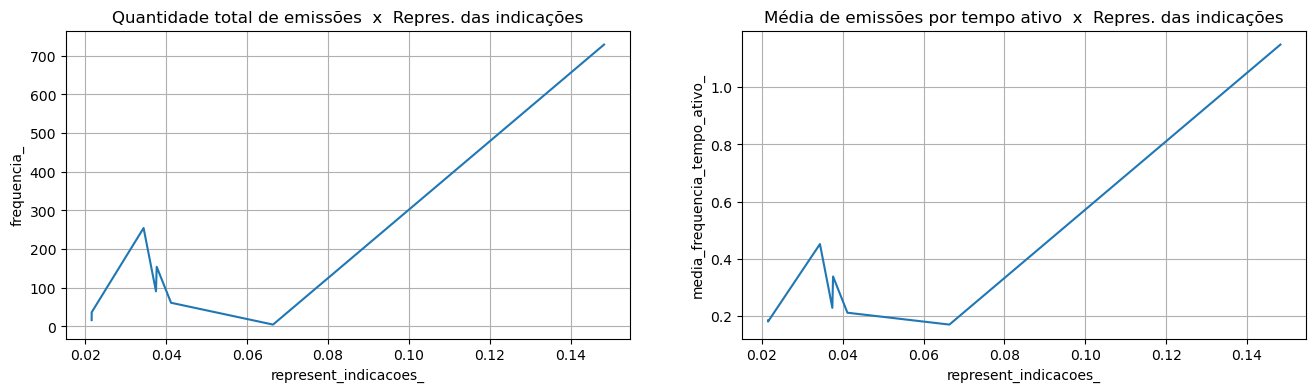

In [96]:
plt.figure(figsize=[16, 4])
# total de emissões (frequência)
plt.subplot(1, 2, 1)
aux = df10a.loc[:, ['cluster', 'represent_indicacoes', 'frequencia']].groupby('cluster').agg(represent_indicacoes_ = ('represent_indicacoes', 'mean'),
                                                                                                       frequencia_ = ('frequencia', 'mean')).reset_index()
sns.lineplot(x='represent_indicacoes_', y='frequencia_', data=aux)
plt.title('Quantidade total de emissões  x  Repres. das indicações')
plt.grid()

# media_frequencia_tempo_ativo
plt.subplot(1, 2, 2)
aux = df10a.loc[:, ['cluster', 'represent_indicacoes', 'media_frequencia_tempo_ativo']].groupby('cluster').agg(represent_indicacoes_ = ('represent_indicacoes', 'mean'),
                                                                                                       media_frequencia_tempo_ativo_ = ('media_frequencia_tempo_ativo', 'mean')).reset_index()
sns.lineplot(x='represent_indicacoes_', y='media_frequencia_tempo_ativo_', data=aux)  
plt.title('Média de emissões por tempo ativo  x  Repres. das indicações')
plt.grid();

### H2. As unidades do cluster Campeões emitem mais de 30% do total geral da base de unidades no mês mais atual.

**VERDADEIRO** O cluster Campeões possui mais de 30% das emissões da base.

Representatividade das emissões do cluster Campeões: 40.0%


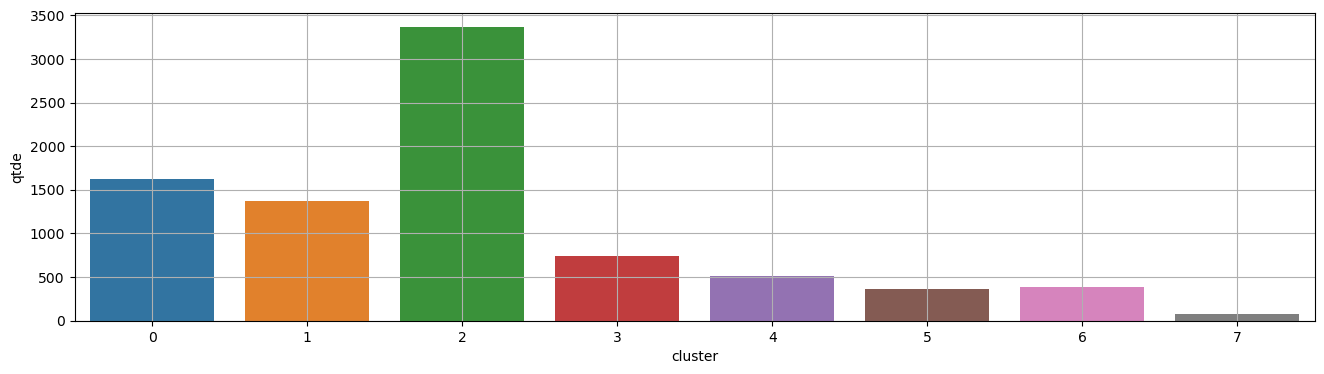

In [97]:
aux = df10b[df10b['ano_mes']=='2022-11'][['qtde', 'cluster']].groupby('cluster').sum().reset_index()
aux2 = df10b[df10b['ano_mes']=='2022-11']['qtde'].sum()
print('Representatividade das emissões do cluster Campeões: {}%'.format(np.round(100*aux.loc[2, 'qtde']/aux2), 2))
plt.figure(figsize=[16, 4])
sns.barplot(x='cluster', y='qtde', data=aux)
plt.grid()

### H3. As unidades do cluster Campeões faturam mais de 30% do total geral da base de unidades no mês mais atual.

**VERDADEIRO** O cluster Campeões fatura mais de 30% do total da base.

Representatividade do faturamento do cluster Campeões: 36.0%


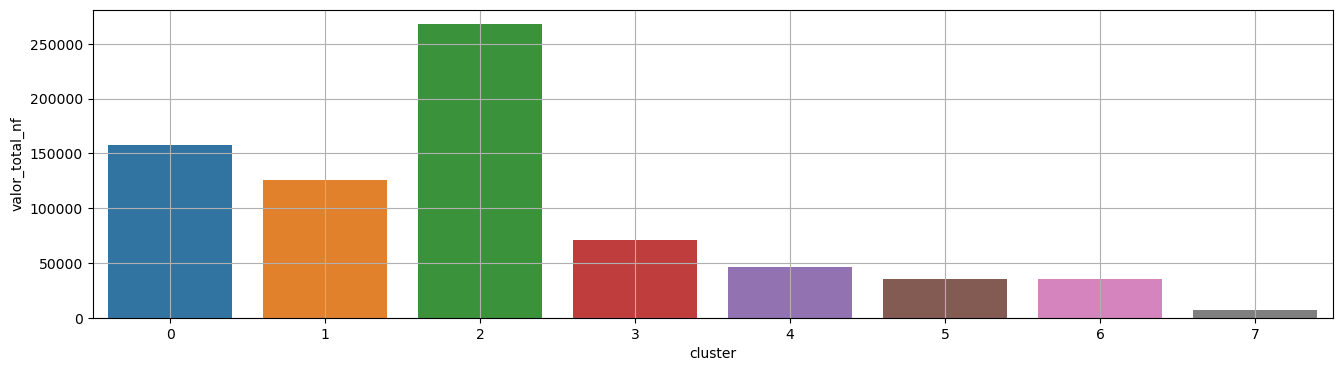

In [112]:
aux = df10b[df10b['ano_mes']=='2022-11'][['valor_total_nf', 'cluster']].groupby('cluster').sum().reset_index()
aux2 = df10b[df10b['ano_mes']=='2022-11']['valor_total_nf'].sum()
print('Representatividade do faturamento do cluster Campeões: {}%'.format(np.round(100*aux.loc[2, 'valor_total_nf']/aux2), 2))
plt.figure(figsize=[16, 4])
sns.barplot(x='cluster', y='valor_total_nf', data=aux)
plt.grid()

### H4. O cluster Campeões tem uma média de revogações de certificados menor que a dos outros clusters.

**FALSO** O cluster Campeões revoga mais que os outros clusters (provavelmente porque emitem muito mais que os outros clusters).

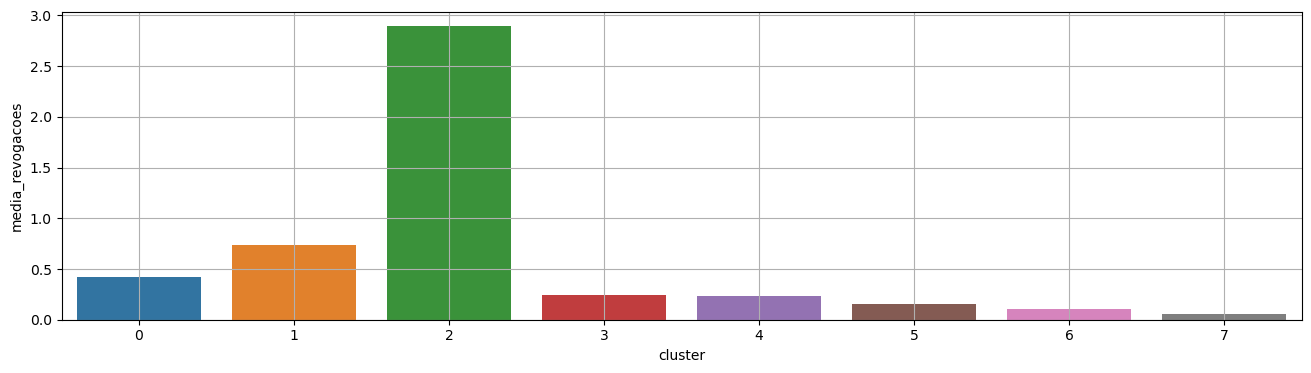

In [99]:
aux = df10a[['cluster', 'qtde_revogados']].groupby('cluster').mean().reset_index().rename(columns={'qtde_revogados': 'media_revogacoes'})
plt.figure(figsize=[16, 4])
sns.barplot(x='cluster', y='media_revogacoes', data=aux)
plt.grid()

### H5. O cluster Campeões é formado por 70% de unidades captadas por Prospecção.

**FALSO** O cluster Campeões é formado por 81,33% de unidades do tipo Prospecção.

In [100]:
aux = df10b[['cluster', 'empresa_unidade', 'segmento']].drop_duplicates(subset='empresa_unidade')
aux = aux[aux['cluster']==2]
aux = aux[['segmento']].groupby('segmento').size().reset_index()
aux = aux.set_index('segmento')
print('Representatividade do segmento prospecção: {}%'.format(np.round(100*aux.loc['PROSPECCAO', 0]/aux[0].sum(), 2)))

Representatividade do segmento prospecção: 81.33%


### H6. O cluster Campeões é formado, em maior parte, pelas regiões do Sudeste e Nordeste, respectivamente.

**FALSO** O cluster Campeões é formado principalmente por unidades das regiões Sudeste e Centro-Oeste.

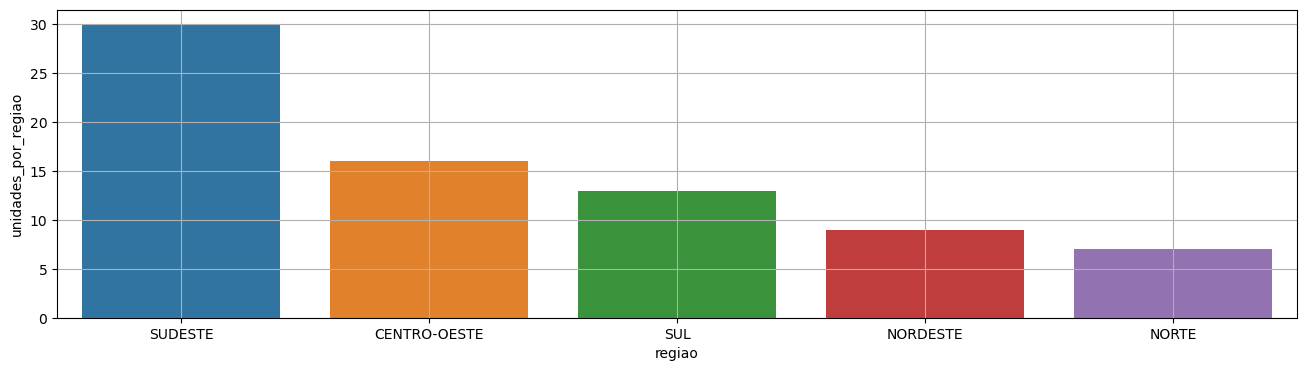

In [101]:
aux = df10b[['cluster', 'regiao', 'empresa_unidade']].drop_duplicates(subset='empresa_unidade')
aux = aux[aux['cluster']==2]
aux = aux[['regiao']].groupby('regiao').size().reset_index().rename(columns={0: 'unidades_por_regiao'})
aux = aux.sort_values('unidades_por_regiao', ascending=False)
plt.figure(figsize=[16, 4])
sns.barplot(x='regiao', y='unidades_por_regiao', data=aux)
plt.grid()

### H7. O cluster Campeões é formado em sua maioria por unidades do estado de Minas Gerais.

**FALSO** O cluster Campeões tem unidades distribuídas por todo o Brasil, não havendo um estado que tenha a maioria.

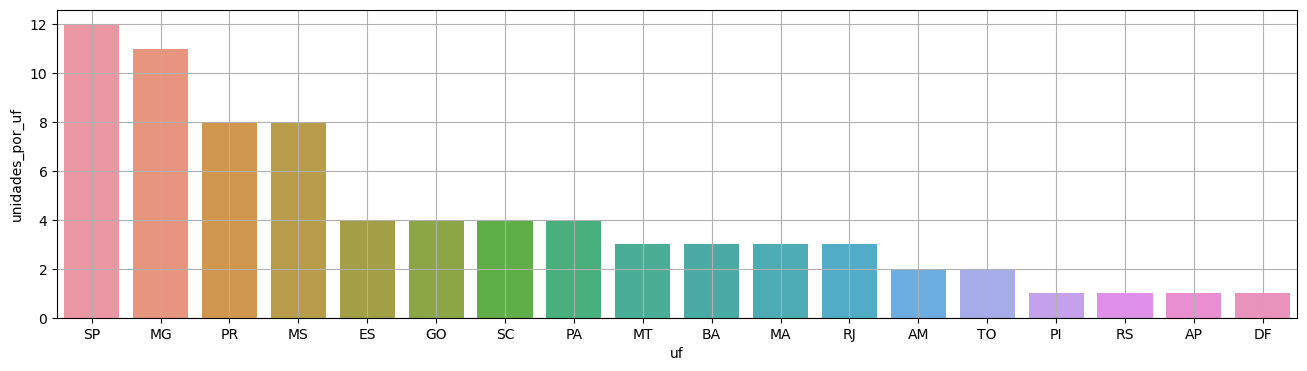

In [102]:
aux = df10b[['cluster', 'uf', 'empresa_unidade']].drop_duplicates(subset='empresa_unidade')
aux = aux[aux['cluster']==2]
aux = aux[['uf']].groupby('uf').size().reset_index().rename(columns={0: 'unidades_por_uf'})
aux = aux.sort_values('unidades_por_uf', ascending=False)
plt.figure(figsize=[16, 4])
sns.barplot(x='uf', y='unidades_por_uf', data=aux)
plt.grid()

### H8. O cluster Campeões é formado por 60% de unidades com mais 1 ano (365 dias) de tempo ativo.

**FALSO** O cluster Campeões é formado por 89,33% de unidades com mais de 365 dias de tempo ativo.

Representatividade das unidades com mais 365 dias de tempo ativo: 89.33%


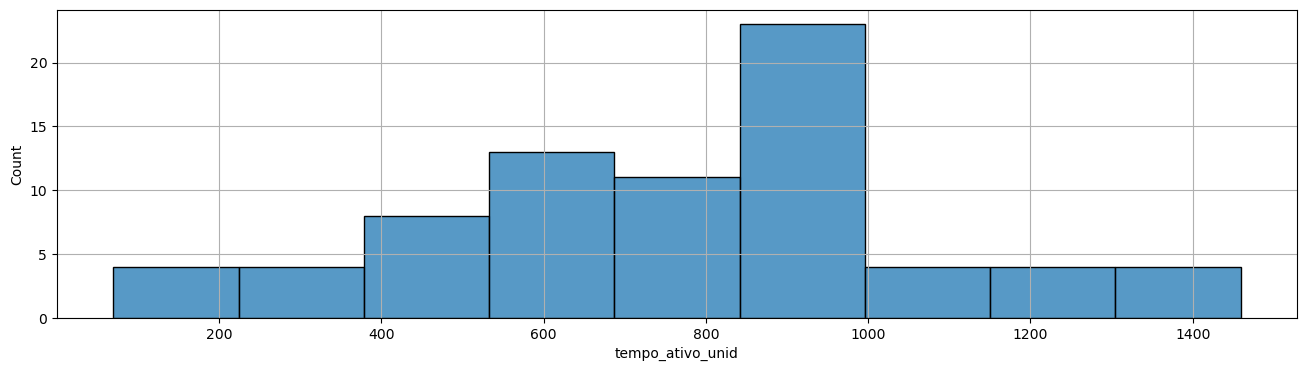

In [103]:
aux = df10b[['cluster', 'tempo_ativo_unid', 'empresa_unidade']].drop_duplicates(subset='empresa_unidade')
aux = aux[aux['cluster']==2]
print('Representatividade das unidades com mais 365 dias de tempo ativo: {}%'.format(np.round(100*aux[aux['tempo_ativo_unid']>=365].shape[0]/aux.shape[0], 2)))
plt.figure(figsize=[16, 4])
sns.histplot(x='tempo_ativo_unid', data=aux)
plt.grid()

### H9. O cluster Campeões possuem uma média de pedidos por qtde de análises maior que a dos outros clusters.

**VERDADEIRO** O cluster Campeões possui uma média de pedidos por qtde de análises maior que os outros clusters.

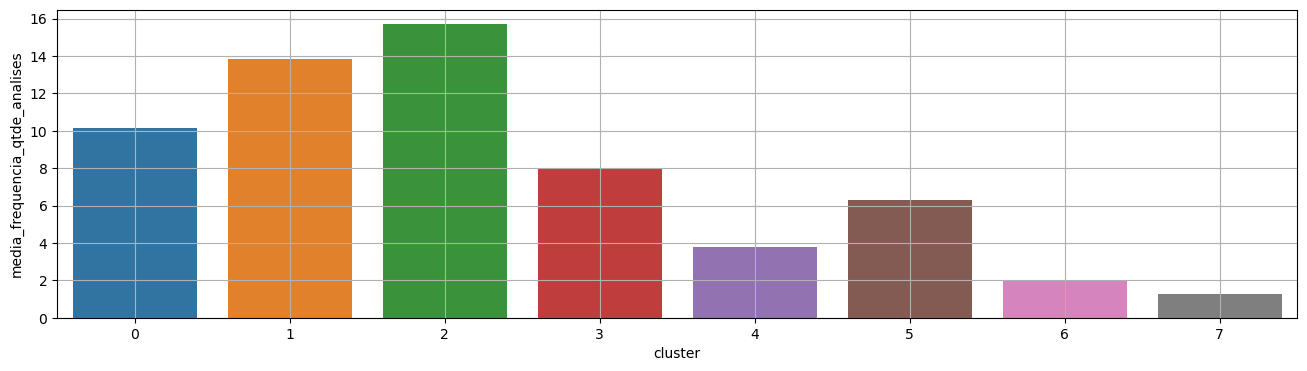

In [104]:
aux = df10a[['cluster', 'media_frequencia_qtde_analises',]].groupby('cluster').mean().reset_index()
plt.figure(figsize=[16, 4])
sns.barplot(x='cluster', y='media_frequencia_qtde_analises', data=aux)
plt.grid()

### H10. A taxa de renovação do cluster Campeões é maior do que qualquer outro cluster.

**VERDADEIRO** O cluster Campeões possui a maior média de represent. de renovacões dentre os clusters.

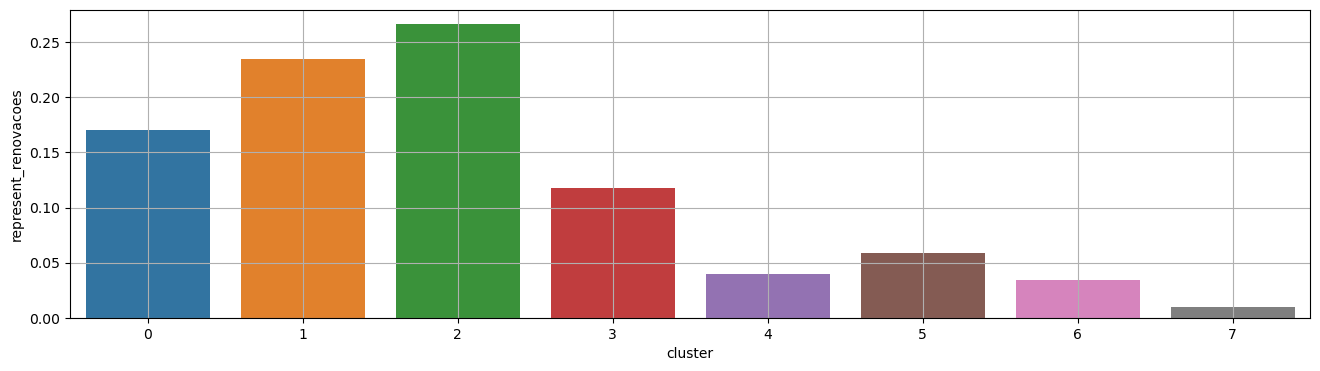

In [105]:
aux = df10a[['cluster', 'represent_renovacoes']].groupby('cluster').mean().reset_index()
plt.figure(figsize=[16, 4])
sns.barplot(x='cluster', y='represent_renovacoes', data=aux)
plt.grid()

## 10.3 - Respondendo às questões propostas

### Quem são as unidades elegíveis para participar do melhor grupo?

As unidades que tiverem os maiores números em:
 - Unidade que gera um alto faturamento
 - Tem uma taxa de emissão de certificados por tempo ativo alta
 - Baixa probabilidade de churn
 - Baixa recência e alta frequência
 - Relação qtde de análises/qtde de certificados emitidos baixa
 - Relação qtde de pedidos revogados/qtdede certificados emitidos baixa

### Quantas unidades farão parte do grupo?

In [109]:
print('Neste exato momento, {} unidades farão parte do cluster Campeões.'.format(df10a[df10a['cluster']==2].shape[0]))

Neste exato momento, 75 unidades farão parte do cluster Campeões.


### Quais as principais características das unidades desse grupo?

In [111]:
df_cluster.loc[2, :].T

cluster                                    2
qtde_unidades                             75
perc_unidade                          10.14%
valor_total_nf                    66865.9828
frequencia                            728.64
media_frequencia_tempo_ativo        1.149159
recencia_dias                           3.08
ticket_medio                       96.179273
media_recencia_dias                 0.793878
qtde_revogados                      2.892392
represent_renovacoes                0.266231
represent_indicacoes                 0.14827
represent_vouchers                  0.014098
media_frequencia_qtde_analises     15.695881
Name: 2, dtype: object

### Qual a porcentagem de contribuição do faturamento vinda deste grupo?

In [113]:
aux = df10b[df10b['ano_mes']=='2022-11'][['valor_total_nf', 'cluster']].groupby('cluster').sum().reset_index()
aux2 = df10b[df10b['ano_mes']=='2022-11']['valor_total_nf'].sum()
print('Representatividade do faturamento do cluster Campeões: {}%'.format(np.round(100*aux.loc[2, 'valor_total_nf']/aux2), 2))

Representatividade do faturamento do cluster Campeões: 36.0%


### Quais as condições para uma pessoa ser elegível ao melhor grupo?

A unidade precisará aproximar seus valores das médias apresentadas acima na pergunta **"Quais as principais características das unidades desse grupo?"**.

### Quais as condições para uma pessoa ser removida do melhor grupo?

A unidade precisará afastar seus valores das médias apresentadas acima na pergunta **"Quais as principais características das unidades desse grupo?"**.

### Sobre os outros grupos, quais ações o time de marketing pode realizar para aumentar o faturamento?

**Os outros clusters definidos pelo modelo aplicado:**

**1**  ->  Cluster Promissores ao Campeões

**0**  ->  Cluster Emitir mais 1

**3**  ->  Cluster Emitir mais 2

**5**  ->  Cluster Sob observação 1

**4**  ->  Cluster Sob observacao 2

**6**  ->  Cluster Aviso de descredenciamento

**7**  ->  Cluster Descredenciar

- Para os clusters 1, 0 e 3 seria interessante incentivar que buscassem parceiros indicadores para criar uma fonte mais frequente de solicitação de emissões de certificados.
- Para os clusters 5 e 4 é importante incentivar o fechamento de parcerias de indicação, aumentar a quantidade de certificados renovados e reduzir a taxa qtde certificados por qtde de análises
- Para o cluster 6, além de fazer os incentivos citados acima, deve-se comunicar sobre a possibilidade de descredenciamento.
- Para o cluster 7, caso não seja uma unidade nova, deve-se solicitar o descredenciamento da unidade.